# Autoimmune GWAS genes vs perturb-seq clusters analysis

This notebook visualizes the results of the OpenTargets autoimmune disease enrichment analysis (output of opentargets_autoimmune_analysis.py).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

import sys
sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

In [2]:
import yaml
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [14]:
%%bash
DATADIR=/mnt/oak/users/emma/data/GWT/
DROPBOX_PATH=GRNPerturbSeq/3_expts/processed_data/analysis_largefiles/
rclone copy "dropbox:${DROPBOX_PATH}" "${DATADIR}/CD4i_final/" \
  --include "*nde75ntotal50_varfiltered_simple_clustering*.h5ad" \
  --size-only -v

rclone copy "dropbox:${DROPBOX_PATH}" "${DATADIR}/CD4i_final/" \
  --include "*nde75ntotal50_varfiltered_simple_clustering_downstream_genes*.csv" \
  --size-only -v

2025/10/28 16:52:45 INFO  : 
Transferred:   	    2.782 GiB / 2.782 GiB, 100%, 14.649 MiB/s, ETA 0s
Transferred:            0 / 1, 0%
Elapsed time:       1m0.3s
Transferring:
 * nde75ntotal50_varfilte…simple_clustering.h5ad:100% /2.782Gi, 14.649Mi/s, 0s

2025/10/28 16:53:45 INFO  : 
Transferred:   	    2.782 GiB / 2.782 GiB, 100%, 312.163 KiB/s, ETA 0s
Transferred:            0 / 1, 0%
Elapsed time:       2m0.3s
Transferring:
 * nde75ntotal50_varfilte…simple_clustering.h5ad:100% /2.782Gi, 312.164Ki/s, 0s

2025/10/28 16:54:45 INFO  : 
Transferred:   	    2.782 GiB / 2.782 GiB, 100%, 6.496 KiB/s, ETA 0s
Transferred:            0 / 1, 0%
Elapsed time:       3m0.3s
Transferring:
 * nde75ntotal50_varfilte…simple_clustering.h5ad:100% /2.782Gi, 6.496Ki/s, 0s

2025/10/28 16:55:37 INFO  : nde75ntotal50_varfiltered_simple_clustering.h5ad: Multi-thread Copied (new)
2025/10/28 16:55:37 INFO  : 
Transferred:   	    2.782 GiB / 2.782 GiB, 100%, 231 B/s, ETA 0s
Transferred:            1 / 1, 100%
Elap

## Load Data

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [5]:
de_summary_stats = pd.read_csv('/mnt/oak/users/emma/data/GWT/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv')

In [6]:
adata_de.var_names = adata_de.var['gene_name'].values

In [ ]:
# # Load disease-gene associations
# disease_gene_df = pd.read_csv('disease_gene_associations_detailed.csv')
# cormat = pd.read_csv('/mnt/oak/users/emma/data/GWT//CD4i_final/pca_params_screening_nde30ntotal75_varfiltered_neighbor1563resolution24_cooc_matrix.csv', index_col=0)
# conditions = cormat.index.str.split('_').str[1]

# cond_cormats = {}
# zscore_cond_cormats = {}
# coreg_cond_cormats = {}

# for c in np.unique(conditions):
#     cond_cormats[c] = cormat.loc[conditions == c, conditions == c]
#     cond_cormats[c].index = cond_cormats[c].index.str.split('_').str[0]
#     cond_cormats[c].columns = cond_cormats[c].columns.str.split('_').str[0]

#     intersect_gs = np.intersect1d(cond_cormats[c].index, adata_de.obs['target_contrast_gene_name'])
#     adatas_subset = adata_de[(adata_de.obs['culture_condition'] == c) & (adata_de.obs['target_contrast_gene_name'].isin(intersect_gs))]
#     zscore_c = adatas_subset.layers['zscore']
#     zscore_cormat = pd.DataFrame(zscore_c.T).corr()
#     zscore_cormat.index = intersect_gs
#     zscore_cormat.columns = intersect_gs
#     zscore_cond_cormats[c] = zscore_cormat

# basemean_cond_cormats = {}
# for c in np.unique(conditions):
#     # co-expression
    
    
#     intersect_gs = np.intersect1d(cond_cormats[c].index, adata_de.var_names)
#     basemean_c = adata_de[adata_de.obs['culture_condition'] == c, intersect_gs].layers['baseMean']
#     basemean_cormat = pd.DataFrame(basemean_c).corr()
#     basemean_cormat.index = intersect_gs
#     basemean_cormat.columns = intersect_gs
#     basemean_cond_cormats[c] = basemean_cormat
# sns.heatmap(basemean_c[0:200])
# d = "Crohn's disease"
# gene_list = disease_gene_df[disease_gene_df['disease_name'] == d]['gene_symbol'].tolist()

# cormat = zscore_cond_cormats['Stim8hr'].copy()
# perturb_genes = cormat.index
# gene_list = np.intersect1d(gene_list, perturb_genes)

# gene_set_binary_matrix = cormat.copy()
# gene_set_binary_matrix.values.fill(0)
# gene_set_binary_matrix.loc[gene_list, gene_list] = 1

# n_genes = cormat.shape[0]
# upper_tri_indices = np.triu_indices(n_genes, k=1)
    
# # Extract correlation scores and labels for gene pairs
# scores = cormat.values[upper_tri_indices]
# y_true = gene_set_binary_matrix.values[upper_tri_indices]

# precision, recall, thresholds = precision_recall_curve(y_true, scores)
# auprc = auc(recall, precision)
# avg_precision = average_precision_score(y_true, scores)

# # Compute baseline (fraction of positive pairs)
# baseline = y_true.sum() / len(y_true)

# auprc

# cond_cormats[c].loc[disease_genes_in_matrix, disease_genes_in_matrix].reset_index().melt(id_vars='index')
# disease_gene_df.disease_name.unique()
# from statsmodels.distributions.empirical_distribution import ECDF

# c = 'Stim8hr'
# all_corrs = zscore_cond_cormats[c].values.flatten()
# all_corrs = all_corrs[all_corrs != 1] # Mask self-correlations
# ecdf_all = ECDF(all_corrs)
# plt.plot(ecdf_all.x, ecdf_all.y, label='all', color='blue')

# colors = ['red', 'green', 'black']
# for i, d in enumerate(["Crohn's disease", 'autoimmune disease', 'coronary artery disease']):
#     gene_list = disease_gene_df[disease_gene_df['disease_name'] == d]['gene_symbol'].tolist()

#     # Get correlations between disease genes that are in the correlation matrix
#     disease_genes_in_matrix = [g for g in gene_list if g in zscore_cond_cormats[c].columns]

#     # Get correlations and plot ECDF, masking self-correlations
#     disease_corrs = zscore_cond_cormats[c].loc[disease_genes_in_matrix, disease_genes_in_matrix].values.flatten()
#     disease_corrs = disease_corrs[disease_corrs != 1]
#     ecdf_disease = ECDF(disease_corrs)
#     plt.plot(ecdf_disease.x, ecdf_disease.y, color=colors[i], label=f'{d} (n={len(disease_genes_in_matrix)})')

# plt.xlabel('Correlation')
# plt.ylabel('Cumulative Probability')
# plt.legend()
# import numpy as np

# colors = ['red', 'green', 'black', 'blue']
# plt.figure(figsize=(10,6))
# for i, d in enumerate(["Crohn's disease", 'asthma', 'coronary artery disease', 'rheumatoid arthritis']):
#     c = 'Stim8hr'
#     gene_list = disease_gene_df[disease_gene_df['disease_name'] == d]['gene_symbol'].tolist()

#     # Get correlations between disease genes that are in the correlation matrix
#     disease_genes_in_matrix = [g for g in gene_list if g in basemean_cond_cormats[c].columns]

#     # Get correlations, masking self-correlations
#     disease_corrs = basemean_cond_cormats[c].loc[disease_genes_in_matrix, disease_genes_in_matrix].values.flatten()
#     disease_corrs = disease_corrs[disease_corrs != 1]

#     # Plot line
#     plt.plot(sorted(disease_corrs), np.linspace(0, 1, len(disease_corrs)), 
#             color=colors[i], label=f'{d} (n={len(disease_genes_in_matrix)})')
    
#     # Add dotted line for mean
#     mean = np.mean(disease_corrs)
#     plt.axvline(x=mean, color=colors[i], linestyle=':', alpha=0.5)

# plt.xlabel('Correlation')
# plt.ylabel('Density')
# plt.legend()
# import numpy as np

# colors = ['red', 'green', 'black', 'blue']
# plt.figure(figsize=(10,6))
# for i, d in enumerate(["Crohn's disease", 'asthma', 'coronary artery disease', 'rheumatoid arthritis']):
#     c = 'Stim8hr'
#     gene_list = disease_gene_df[disease_gene_df['disease_name'] == d]['gene_symbol'].tolist()

#     # Get correlations between disease genes that are in the correlation matrix
#     disease_genes_in_matrix = [g for g in gene_list if g in zscore_cond_cormats[c].columns]

#     # Get correlations, masking self-correlations
#     disease_corrs = zscore_cond_cormats[c].loc[disease_genes_in_matrix, disease_genes_in_matrix].values.flatten()
#     disease_corrs = disease_corrs[disease_corrs != 1]

#     # Plot line
#     plt.plot(sorted(disease_corrs), np.linspace(0, 1, len(disease_corrs)), 
#             color=colors[i], label=f'{d} (n={len(disease_genes_in_matrix)})')
    
#     # Add dotted line for mean
#     mean = np.mean(disease_corrs)
#     plt.axvline(x=mean, color=colors[i], linestyle=':', alpha=0.5)

# plt.xlabel('Correlation')
# plt.ylabel('Density')
# plt.legend()

In [15]:
# All clustered perturbations
cl_a = anndata.experimental.read_lazy('/mnt/oak/users/emma/data/GWT//CD4i_final/nde75ntotal50_varfiltered_simple_clustering.h5ad')
clustering_df = cl_a.obs.to_dataframe()[['hdbscan', 'target_contrast_gene_name_corrected']]

In [16]:
# Load disease-gene associations
disease_gene_df = pd.read_csv('disease_gene_associations_detailed.csv')
disease_gene_df['disease_name'].unique()

array(["Crohn's disease", "Hashimoto's thyroiditis",
       'age-related macular degeneration', 'ankylosing spondylitis',
       'asthma', 'atopic eczema', 'autoimmune disease', 'celiac disease',
       'chronic kidney disease', 'coronary artery disease',
       'inflammatory bowel disease', 'multiple sclerosis', 'psoriasis',
       'rheumatoid arthritis', 'systemic lupus erythematosus',
       'type 1 diabetes mellitus', 'ulcerative colitis'], dtype=object)

## Enrichment of disease-associated genes

In [17]:
from scipy.stats.contingency import odds_ratio
from scipy.stats import fisher_exact
import pandas as pd
import numpy as np

def get_enrichment(cl_genes, disease_genes, background_genes):
    # Create contingency table
    # Convert lists to sets for set operations
    cl_genes_set = set(cl_genes)
    disease_genes_set = set(disease_genes)
    
    in_cluster_in_disease = len(cl_genes_set & disease_genes_set)
    in_cluster_not_disease = len(cl_genes_set - disease_genes_set)
    not_cluster_in_disease = len(disease_genes_set - cl_genes_set)
    not_cluster_not_disease = len(background_genes - cl_genes_set - disease_genes_set)
        
    contingency_table = np.array([
        [in_cluster_in_disease, not_cluster_in_disease],
        [in_cluster_not_disease, not_cluster_not_disease]
    ])

    # Calculate statistics
    or_res = odds_ratio(contingency_table)
    oratio = or_res.statistic
    _, p_value = fisher_exact(contingency_table, alternative='greater')
    or_ci = or_res.confidence_interval(confidence_level=0.95)
    
    # Create results dataframe
    results = pd.DataFrame({
        'odds_ratio': [oratio],
        'p_value': [p_value], 
        'ci_low': [or_ci.low],
        'ci_high': [or_ci.high],
        'cluster_size':[len(cl_genes_set)],
        'in_cluster_in_disease': [in_cluster_in_disease],
        'in_cluster_not_disease': [in_cluster_not_disease],
        'not_cluster_in_disease': [not_cluster_in_disease],
        'not_cluster_not_disease': [not_cluster_not_disease],
        'intersecting_genes': [list(cl_genes_set & disease_genes_set)]
    })
    
    return results

### Upstream regulators

In [ ]:
background_genes = set(de_summary_stats[(de_summary_stats.n_total_de_genes>75)&(de_summary_stats.n_cells_target>50)].target_name.unique())
print(len(background_genes))

1992


In [53]:

# Get background genes for this analysis (all genes used for clustegin)
background_genes = set(de_summary_stats[(de_summary_stats.n_total_de_genes>75)&(de_summary_stats.n_cells_target>50)].target_name.unique())

# Filter clusters by minimum size
test_disease_gene_df = disease_gene_df[disease_gene_df.gene_symbol.isin(background_genes)].copy()

# Initialize empty list to store results
all_results = []
hg_all_results = []

for cl in clustering_df['hdbscan'].unique():
    test_clustering_df = clustering_df[clustering_df['hdbscan'] == cl].copy()
    cl_genes = set(test_clustering_df['target_contrast_gene_name_corrected'].unique())
    for d in test_disease_gene_df.disease_name.unique():
        disease_genes = test_disease_gene_df[test_disease_gene_df.disease_name == d].gene_symbol
        # Get enrichment results for this cluster-disease pair
        # Only run enrichment if overlap > 1
        overlap = len(cl_genes & set(disease_genes))
        if overlap > 1:
            result_df = get_enrichment(cl_genes,
                                     disease_genes, 
                                     background_genes)

            # Add cluster and disease info
            result_df['cluster'] = cl
            result_df['disease'] = d
            all_results.append(result_df)
    

# Concatenate all results into single dataframe        
enrichment_results = pd.concat(all_results, ignore_index=True)

# Run BH correction for each cluster separately
enrichment_results['p_adj_fdr'] = 1.0  # Initialize with 1.0
for cluster in enrichment_results['cluster'].unique():
    mask = enrichment_results['cluster'] == cluster
    enrichment_results.loc[mask, 'p_adj_fdr'] = multipletests(enrichment_results.loc[mask, 'p_value'], method='fdr_bh')[1]


In [54]:
enrichment_results.sort_values('p_adj_fdr')[0:20]

,odds_ratio,p_value,ci_low,ci_high,cluster_size,in_cluster_in_disease,in_cluster_not_disease,not_cluster_in_disease,not_cluster_not_disease,intersecting_genes,cluster,disease,p_adj_fdr
62,2.499814,0.000525,1.441374,4.272728,405,26,379,39,1422,"[UBE2E1, ARRDC4, DMAC1, FOXO1, IMMP2L, USP24, ...",-1,ankylosing spondylitis,0.002975
65,1.596041,0.000497,1.206971,2.100621,405,96,309,238,1223,"[ACTB, GATA3, ATXN10, CCDC6, COMMD7, EIF4H, NA...",-1,autoimmune disease,0.002975
72,2.023167,0.000458,1.332630,3.036493,405,42,363,79,1382,"[UBE2E1, GATA3, ARRDC4, CNOT4, DMAC1, ZEB1, CC...",-1,rheumatoid arthritis,0.002975
356,29.682665,0.000688,3.895120,226.252025,6,3,3,60,1795,"[BATF, IPMK, STAT3]",79,Crohn's disease,0.004817
278,13.215038,0.006093,1.752550,99.652757,6,3,3,130,1724,"[HDAC3, TBL1XR1, NCOR1]",19,asthma,0.006093
64,2.429174,0.003427,1.272384,4.538023,405,19,386,29,1432,"[BATF, GATA3, WNK1, ZBTB1, TRAF6, FOSL2, ID2, ...",-1,atopic eczema,0.014565
357,19.532000,0.009148,1.726172,140.245491,6,2,4,46,1809,"[BATF, STAT3]",79,atopic eczema,0.019417
359,12.401120,0.007185,1.645477,93.465267,6,3,3,138,1717,"[BATF, IPMK, STAT3]",79,inflammatory bowel disease,0.019417
360,17.580282,0.011095,1.557102,125.884303,6,2,4,51,1804,"[BATF, STAT3]",79,multiple sclerosis,0.019417
368,10.991729,0.007750,1.591780,65.787389,7,3,4,118,1735,"[RBPJ, IL4R, DMRTA2]",85,rheumatoid arthritis,0.023250


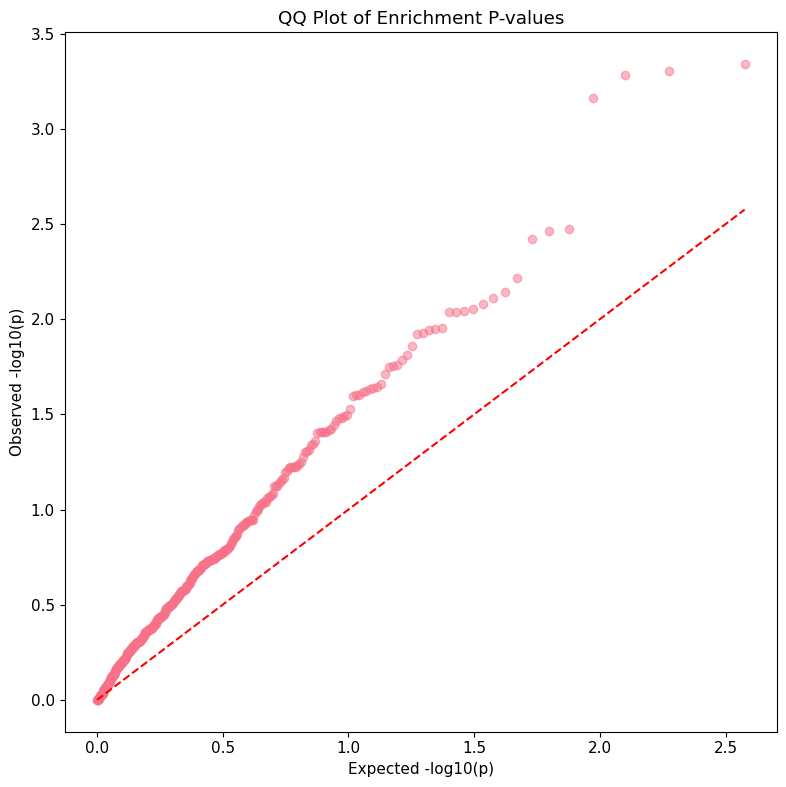

In [55]:
# Create QQ plot of p-values
observed_p = -np.log10(sorted(enrichment_results['p_value']))
expected_p = -np.log10(np.linspace(0, 1, len(observed_p)+2)[1:-1])

plt.figure(figsize=(8,8))
plt.scatter(expected_p, observed_p, alpha=0.5)
plt.plot([0, max(expected_p)], [0, max(expected_p)], 'r--')
plt.xlabel('Expected -log10(p)')
plt.ylabel('Observed -log10(p)') 
plt.title('QQ Plot of Enrichment P-values')
plt.tight_layout()
plt.show()

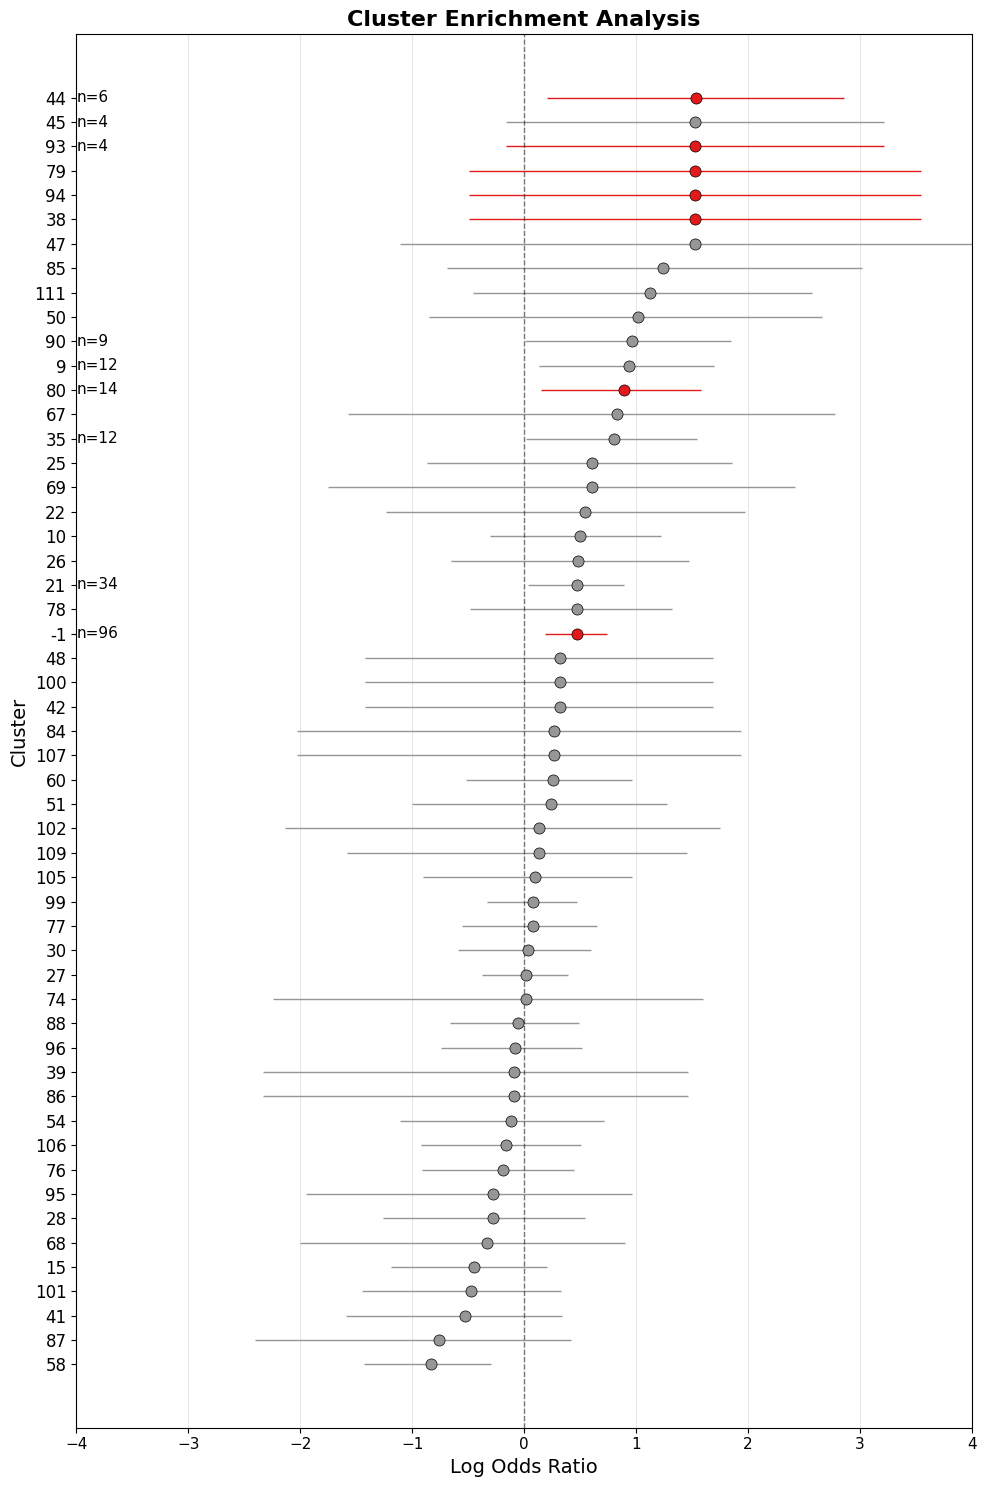

In [56]:
enrichment_results_df = enrichment_results[enrichment_results.disease == 'autoimmune disease'].copy()

# Create single forest plot with all clusters
# Sort clusters by odds ratio
enrichment_results_df['cluster'] = enrichment_results_df['cluster'].astype(str)
enrichment_results_df = enrichment_results_df.sort_values('odds_ratio', ascending=True)
fig, ax = plt.subplots(figsize=(10, 15))

# Plot log odds ratios and confidence intervals
y_pos = np.arange(len(enrichment_results_df))

# Color by significance (only red for nominal significance)
colors = ['#e31a1c' if p < 0.1 else '#969696' for p in enrichment_results_df['p_adj_fdr']]

# Plot error bars with colors matching points
for i, (_, row) in enumerate(enrichment_results_df.iterrows()):
    color = '#e31a1c' if row['p_adj_fdr'] < 0.1 else '#969696'
    ax.errorbar(np.log(row['odds_ratio']), i,
               xerr=[[np.log(row['odds_ratio']) - np.log(row['ci_low'])], 
                    [np.log(row['ci_high']) - np.log(row['odds_ratio'])]],
               fmt='o', color=color, ecolor=color,
               elinewidth=1, capsize=0, markersize=8,
               markeredgecolor='black', markeredgewidth=0.5)

# Add vertical line at OR=1 (log(OR)=0)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(enrichment_results_df['cluster'], fontsize=12)
ax.set_xlabel('Log Odds Ratio', fontsize=14)
ax.set_ylabel('Cluster', fontsize=14)
ax.set_title('Cluster Enrichment Analysis', fontsize=16, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add gene counts inside plot area, but only for significant tests
for i, (_, row) in enumerate(enrichment_results_df.iterrows()):
    if row['p_value'] < 0.05:
        in_cluster = int(row['in_cluster_in_disease'])
        ax.text(-4, i, f'n={in_cluster}', ha='left', va='center', fontsize=11)

# Set reasonable x-axis limits
ax.set_xlim(-4, 4)

plt.tight_layout()

In [23]:
enrichment_df = enrichment_results.copy()

### Downstream genes

In [57]:
df_downstream = pd.read_csv('/mnt/oak/users/emma/data/GWT/CD4i_final/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)
df_downstream_top = df_downstream[(df_downstream['zscore_rank_negative_regulation']<50)|(df_downstream['zscore_rank_positive_regulation']<50)].copy()

df_downstream_top.head()

,hdbscan_cluster,downstream_gene,downstream_gene_ids,num_of_upstream,sign_coherence,zscore_rank_negative_regulation,zscore_rank_positive_regulation
217,21,CAPN1,ENSG00000014216,52,1.000000,10009,43
519,21,NDC1,ENSG00000058804,29,-1.000000,14,10038
657,21,KLF6,ENSG00000067082,64,1.000000,10029,23
798,21,STK10,ENSG00000072786,55,1.000000,10008,44
828,21,EED,ENSG00000074266,46,-0.956522,37,10015


In [58]:
# Get background genes for this analysis (all genes downstream of some cluster - filters to consider highly expressed)
background_genes = set(df_downstream_top.downstream_gene.unique())

# Filter clusters by minimum size
test_disease_gene_df = disease_gene_df[disease_gene_df.gene_symbol.isin(background_genes)].copy()

# Initialize empty list to store results
all_results = []

for cl in df_downstream_top['hdbscan_cluster'].unique():
    test_clustering_df = df_downstream_top[df_downstream_top['hdbscan_cluster'] == cl].copy()
    cl_genes = set(test_clustering_df['downstream_gene'].unique())
    for d in test_disease_gene_df.disease_name.unique():
        disease_genes = test_disease_gene_df[test_disease_gene_df.disease_name == d].gene_symbol
        # Get enrichment results for this cluster-disease pair
        # Only run enrichment if overlap > 1
        overlap = len(cl_genes & set(disease_genes))
        if overlap > 1:
            result_df = get_enrichment(cl_genes,
                                     disease_genes, 
                                     background_genes)

            # Add cluster and disease info
            result_df['cluster'] = cl
            result_df['disease'] = d
            all_results.append(result_df)
    

# Concatenate all results into single dataframe        
enrichment_results = pd.concat(all_results, ignore_index=True)

# Run BH correction for each cluster 
enrichment_results['p_adj_fdr'] = 1.0  
for cluster in enrichment_results['cluster'].unique():
    mask = enrichment_results['cluster'] == cluster
    enrichment_results.loc[mask, 'p_adj_fdr'] = multipletests(enrichment_results.loc[mask, 'p_value'], method='fdr_bh')[1]


In [59]:
enrichment_results.sort_values('p_adj_fdr')[0:30]

,odds_ratio,p_value,ci_low,ci_high,cluster_size,in_cluster_in_disease,in_cluster_not_disease,not_cluster_in_disease,not_cluster_not_disease,intersecting_genes,cluster,disease,p_adj_fdr
1109,3.349103,0.000034,1.887593,5.678672,98,19,79,278,3873,"[CTLA4, IFNG, STAT4, JADE2, PDE4A, CD83, TCF7,...",79,rheumatoid arthritis,0.000543
996,2.474146,0.000045,1.575849,3.829860,98,35,63,761,3390,"[TRAFD1, DUSP16, CTLA4, REXO2, STMN3, MBNL1, R...",59,autoimmune disease,0.000717
412,3.763829,0.000157,1.885329,6.966620,98,13,85,162,3989,"[CCR5, JAK2, LSP1, SEPTIN9, IL12RB2, FKBP5, RE...",38,ulcerative colitis,0.002518
1026,8.382688,0.000196,2.796421,20.999865,98,6,92,32,4119,"[OAS3, VEGFA, OAS1, IFNAR2, CD55, NUDC]",31,age-related macular degeneration,0.003334
1441,2.800437,0.000378,1.559765,4.784727,99,18,81,305,3845,"[KCTD20, MBD2, TNFSF8, HECW2, UBL3, JAK2, WDR3...",46,inflammatory bowel disease,0.004916
1110,3.302299,0.001231,1.557404,6.371098,98,11,87,153,3998,"[RYBP, CD83, TCF7, TNIP2, CTLA4, SH2B3, IKBKE,...",79,systemic lupus erythematosus,0.004924
1102,2.148978,0.000616,1.352695,3.352868,98,32,66,764,3387,"[CTLA4, AEBP2, TGFBR3, IFNG, STAT4, ADGRG5, JA...",79,autoimmune disease,0.004924
1103,5.068960,0.000938,1.904463,11.498941,98,7,91,62,4089,"[CIITA, CTLA4, AEBP2, SH2B3, CD28, UBE2E3, STAT4]",79,celiac disease,0.004924
1098,3.876276,0.002077,1.577901,8.287428,98,8,90,93,4058,"[GPR174, TCF7, CTLA4, SH2B3, SESN1, TRIB2, STA...",79,Hashimoto's thyroiditis,0.006648
890,3.826962,0.000707,1.729497,7.620817,97,10,87,121,4031,"[TIMMDC1, CD69, TNFSF14, RUNX3, IL7R, CARD11, ...",55,multiple sclerosis,0.010603


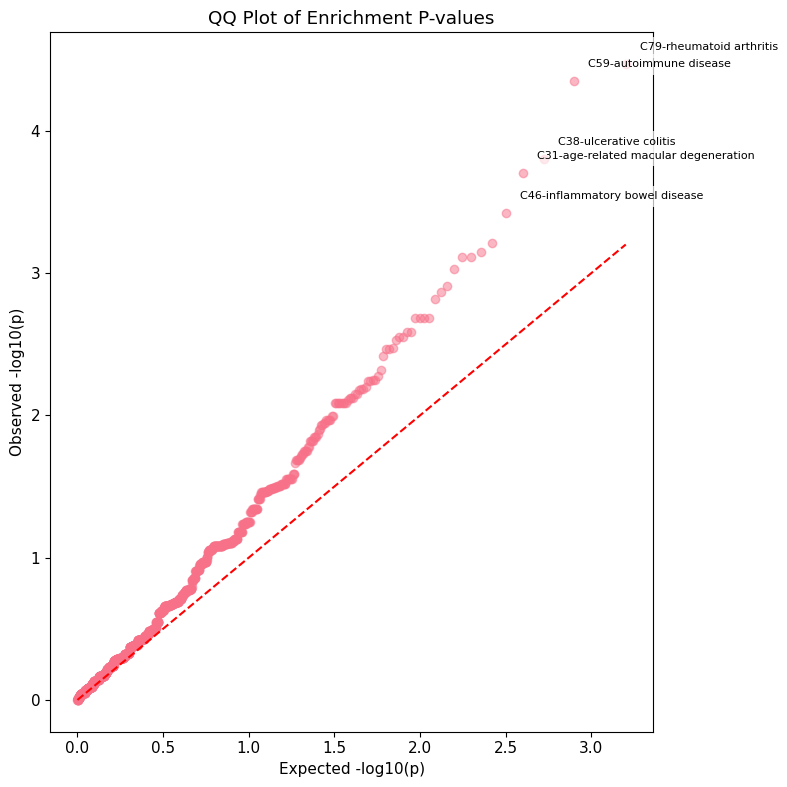

In [60]:
# Create QQ plot of p-values and annotate top cluster-disease pairs
observed_p = -np.log10(sorted(enrichment_results['p_value']))
expected_p = -np.log10(np.linspace(0, 1, len(observed_p)+2)[1:-1])

plt.figure(figsize=(8,8))
plt.scatter(expected_p, observed_p, alpha=0.5)
plt.plot([0, max(expected_p)], [0, max(expected_p)], 'r--')

# Get top 5 most significant cluster-disease pairs
top_pairs = enrichment_results.nsmallest(5, 'p_value')
for _, row in top_pairs.iterrows():
    x = -np.log10(row['p_value'])
    y = observed_p[np.abs(observed_p - x).argmin()]
    plt.annotate(f"C{row['cluster']}-{row['disease']}", 
                xy=(expected_p[np.abs(observed_p - x).argmin()], y),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                fontsize=8)

plt.xlabel('Expected -log10(p)')
plt.ylabel('Observed -log10(p)') 
plt.title('QQ Plot of Enrichment P-values')
plt.tight_layout()
plt.show()

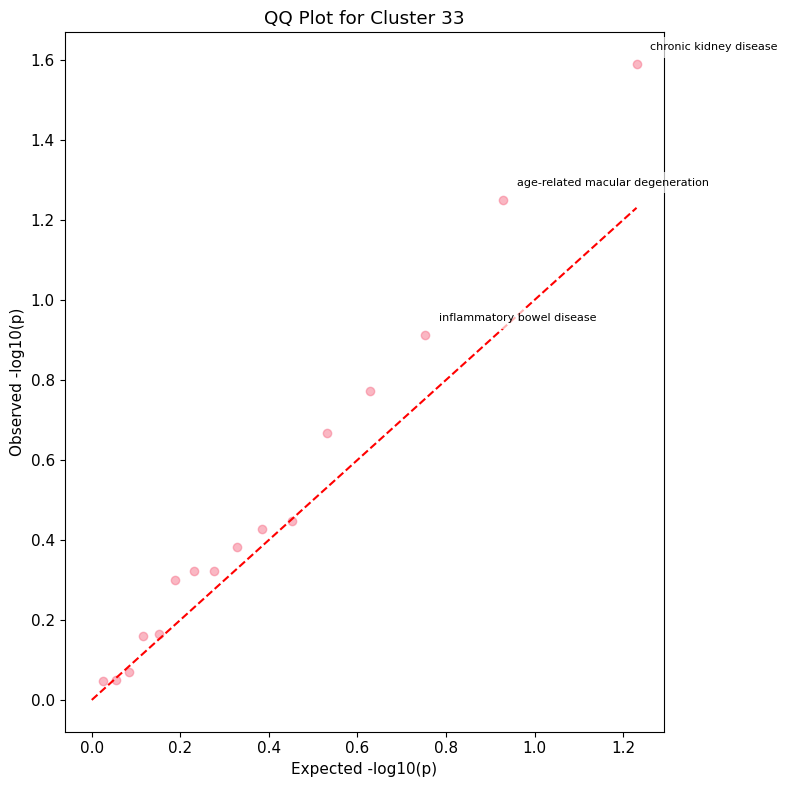

In [61]:
# Create QQ plots for each disease
diseases = enrichment_results['disease'].unique()
n_diseases = len(diseases)

plt.figure(figsize=(8, 8))

for i, cluster in enumerate(enrichment_results['cluster'].unique()):
    if i == 2:
        cluster_results = enrichment_results[enrichment_results['cluster'] == cluster]

        observed_p = -np.log10(sorted(cluster_results['p_value']))
        expected_p = -np.log10(np.linspace(0, 1, len(observed_p)+2)[1:-1])

        plt.scatter(expected_p, observed_p, alpha=0.5)
        plt.plot([0, max(expected_p)], [0, max(expected_p)], 'r--')

        # Get top 3 most significant diseases for this cluster
        top_pairs = cluster_results.nsmallest(3, 'p_value')
        for _, row in top_pairs.iterrows():
            x = -np.log10(row['p_value'])
            y = observed_p[np.abs(observed_p - x).argmin()]
            plt.annotate(f"{row['disease']}", 
                        xy=(expected_p[np.abs(observed_p - x).argmin()], y),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                        fontsize=8)

        plt.xlabel('Expected -log10(p)')
        plt.ylabel('Observed -log10(p)')
        plt.title(f'QQ Plot for Cluster {cluster}')

plt.tight_layout()
plt.show()

In [62]:
downstream_enrichment_df = enrichment_results.copy()

In [63]:
enrichment_df['gene_set'] = 'regulators'
downstream_enrichment_df['gene_set'] = 'downstream'

enrichment_df['cluster'] = enrichment_df.cluster.astype('str')
downstream_enrichment_df['cluster'] = downstream_enrichment_df.cluster.astype('str')

all_enrichment_df = pd.concat([enrichment_df, downstream_enrichment_df])

## Number of genes with genetic association for each disease

<Figure size 1500x1000 with 0 Axes>

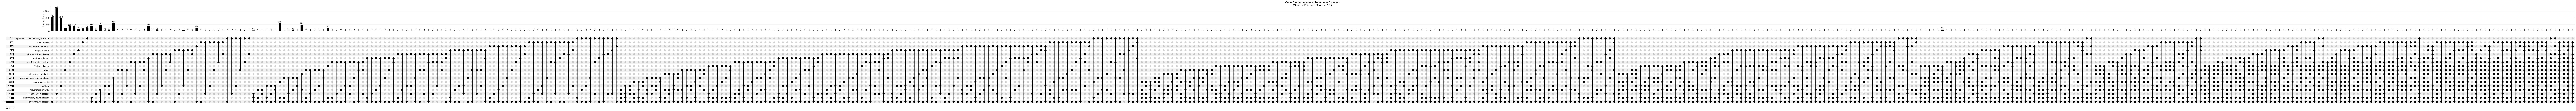

In [64]:
import upsetplot
import matplotlib.pyplot as plt

# Prepare data for upset plot
disease_gene_sets = disease_gene_df[disease_gene_df['genetic_evidence_score'] >= 0.1].groupby('disease_name')['gene_symbol'].apply(set).to_dict()

# Convert to binary indicators for each gene in each disease
all_genes = set.union(*disease_gene_sets.values())
data = pd.DataFrame({
    disease: [gene in genes for gene in all_genes]
    for disease, genes in disease_gene_sets.items()
}, index=list(all_genes))

# Convert to series format expected by upsetplot
data = data.value_counts()

plt.figure(figsize=(15, 10))
upsetplot.plot(data, show_counts=True)
plt.title('Gene Overlap Across Autoimmune Diseases\n(Genetic Evidence Score ≥ 0.1)', fontsize=14)
plt.tight_layout()
plt.show()

## Combined heatmap

In [65]:

# Assign condition labels to each cluster
def get_condition_label(row):
    rest_frac = row['rest_fraction']
    stim8hr_frac = row['stim8hr_fraction']
    stim48hr_frac = row['stim48hr_fraction']
    
    # Multi-condition: all three > 0.1
    if rest_frac > 0.1 and stim8hr_frac > 0.1 and stim48hr_frac > 0.1:
        return 'Multi-condition'
    # Rest-specific
    elif rest_frac > 0.7:
        return 'Rest'
    # Stim8hr-specific
    elif stim8hr_frac > 0.7:
        return 'Stim8hr'
    # Stim48hr-specific
    elif stim48hr_frac > 0.7:
        return 'Stim48hr'
    # Others - assign to dominant condition
    else:
        max_frac = max(rest_frac, stim8hr_frac, stim48hr_frac)
        if max_frac == rest_frac:
            return 'Rest'
        elif max_frac == stim8hr_frac:
            return 'Stim8hr'
        else:
            return 'Stim48hr'


In [33]:
clustering_df['cluster'] = clustering_df['hdbscan'].astype(str).copy()
clustering_df['culture_condition'] = clustering_df.index.str.split('_').str[1]

# Get condition counts per cluster
cluster2condition = clustering_df.groupby('cluster')['culture_condition'].value_counts().reset_index().pivot(index='cluster', columns='culture_condition', values='count')
cluster2condition.sum(1)

# Calculate total cells per cluster
cluster2condition['total'] = cluster2condition.sum(1)

# Calculate fractions
cluster2condition['rest_fraction'] = cluster2condition['Rest'] / cluster2condition['total']
cluster2condition['stim8hr_fraction'] = cluster2condition['Stim8hr'] / cluster2condition['total'] 
cluster2condition['stim48hr_fraction'] = cluster2condition['Stim48hr'] / cluster2condition['total']

# Display results
cluster2condition = cluster2condition[['rest_fraction', 'stim8hr_fraction', 'stim48hr_fraction']].fillna(0)
cluster2condition.head()

cluster2condition['condition_label'] = cluster2condition.apply(get_condition_label, axis=1)


In [34]:
### Combined Heatmap: Regulators and Downstream Gene Enrichment

# Prepare heatmap data for upstream genes
heatmap_data = enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='odds_ratio', 
    fill_value=1.0
)

# Get significance data for downstream
sig_fdr = enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='p_adj_fdr', 
    fill_value=1.0
) < 0.1

sig_nominal = enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='p_value', 
    fill_value=1.0
) < 0.05


# Prepare heatmap data for downstream genes
heatmap_data_downstream = downstream_enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='odds_ratio', 
    fill_value=1.0
)

# Get significance data for downstream
sig_fdr_downstream = downstream_enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='p_adj_fdr', 
    fill_value=1.0
) < 0.1

sig_nominal_downstream = downstream_enrichment_df.pivot_table(
    index='cluster', 
    columns='disease', 
    values='p_value', 
    fill_value=1.0
) < 0.05

# Use union of clusters present in both analyses
all_clusters = sorted(set(heatmap_data.index) | set(heatmap_data_downstream.index))

# Reindex all dataframes to have same clusters (fill missing with 1.0 = no enrichment)
heatmap_perturbed = heatmap_data.reindex(all_clusters, fill_value=1.0)
heatmap_downstream_aligned = heatmap_data_downstream.reindex(all_clusters, fill_value=1.0)

# Use same disease ordering for all (union of diseases)
all_diseases = sorted(set(heatmap_perturbed.columns) | set(heatmap_downstream_aligned.columns))
heatmap_perturbed = heatmap_perturbed.reindex(columns=all_diseases, fill_value=1.0)
heatmap_downstream_aligned = heatmap_downstream_aligned.reindex(columns=all_diseases, fill_value=1.0)

# Get significance data aligned to new ordering
sig_fdr_perturbed_aligned = sig_fdr.reindex(index=all_clusters, columns=all_diseases, fill_value=False)
sig_nominal_perturbed_aligned = sig_nominal.reindex(index=all_clusters, columns=all_diseases, fill_value=False)
sig_fdr_downstream_aligned = sig_fdr_downstream.reindex(index=all_clusters, columns=all_diseases, fill_value=False)
sig_nominal_downstream_aligned = sig_nominal_downstream.reindex(index=all_clusters, columns=all_diseases, fill_value=False)

# Keep only clusters with at least one nominally significant result
has_sig_result = (sig_nominal_perturbed_aligned.any(axis=1) | 
                 sig_nominal_downstream_aligned.any(axis=1))

clusters_to_keep = has_sig_result[has_sig_result].index

# Filter all data to keep only significant clusters
heatmap_perturbed = heatmap_perturbed.loc[clusters_to_keep]
heatmap_downstream_aligned = heatmap_downstream_aligned.loc[clusters_to_keep]

sig_fdr_perturbed_aligned = sig_fdr_perturbed_aligned.loc[clusters_to_keep]
sig_nominal_perturbed_aligned = sig_nominal_perturbed_aligned.loc[clusters_to_keep]
sig_fdr_downstream_aligned = sig_fdr_downstream_aligned.loc[clusters_to_keep]
sig_nominal_downstream_aligned = sig_nominal_downstream_aligned.loc[clusters_to_keep]

# Convert to log scale
log_odds_perturbed = np.log2(heatmap_perturbed.clip(lower=0.1)).replace([np.inf, -np.inf], 0)
log_odds_downstream_aligned = np.log2(heatmap_downstream_aligned.clip(lower=0.1)).replace([np.inf, -np.inf], 0)

# Cluster rows based on combined data from both panels
combined_for_clustering = pd.concat([log_odds_perturbed, log_odds_downstream_aligned], axis=1)
row_linkage_combined = hierarchy.linkage(combined_for_clustering, method='average')
row_dendrogram_combined = hierarchy.dendrogram(row_linkage_combined, no_plot=True)
row_order_combined = row_dendrogram_combined['leaves']

# Cluster columns separately for each panel
col_linkage_perturbed = hierarchy.linkage(log_odds_perturbed.T, method='average')
col_dendrogram_perturbed = hierarchy.dendrogram(col_linkage_perturbed, no_plot=True)
col_order_perturbed = col_dendrogram_perturbed['leaves']

col_linkage_downstream = hierarchy.linkage(log_odds_downstream_aligned.T, method='average')
col_dendrogram_downstream = hierarchy.dendrogram(col_linkage_downstream, no_plot=True)
col_order_downstream = col_dendrogram_downstream['leaves']

# Reorder all matrices
log_odds_perturbed = log_odds_perturbed.iloc[row_order_combined].iloc[:, col_order_perturbed]
log_odds_downstream_aligned = log_odds_downstream_aligned.iloc[row_order_combined].iloc[:, col_order_downstream]

# Create row labels with cluster ID
row_labels_combined = [f"Cluster {cluster_id}" for cluster_id in log_odds_perturbed.index]

# Reorder significance matrices
sig_fdr_perturbed_aligned = sig_fdr_perturbed_aligned.iloc[row_order_combined].iloc[:, col_order_perturbed]
sig_nominal_perturbed_aligned = sig_nominal_perturbed_aligned.iloc[row_order_combined].iloc[:, col_order_perturbed]
sig_fdr_downstream_aligned = sig_fdr_downstream_aligned.iloc[row_order_combined].iloc[:, col_order_downstream]
sig_nominal_downstream_aligned = sig_nominal_downstream_aligned.iloc[row_order_combined].iloc[:, col_order_downstream]

# Align cluster2condition with the same row ordering
cluster2condition_aligned = cluster2condition.reindex(log_odds_perturbed.index)

NameError: name 'hierarchy' is not defined

In [36]:
# Create figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, max(5, len(row_labels_combined) * 0.23)), 
                                     gridspec_kw={'width_ratios': [0.5, 1, 1], 'wspace': 0.05})

# Left panel: Condition distribution
sns.heatmap(cluster2condition_aligned,
            cmap='Reds',
            cbar=False,
            xticklabels=True,
            yticklabels=row_labels_combined,
            ax=ax1)

ax1.set_title('Condition Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Condition', fontsize=10)
ax1.set_ylabel('Regulator cluster', fontsize=10)
ax1.tick_params(axis='x', rotation=90, labelsize=9)
ax1.tick_params(axis='y', labelsize=8)

# Middle panel: Perturbed genes (regulators)
sns.heatmap(log_odds_perturbed,
            cmap='RdYlBu_r',
            center=0,
            annot=False, 
            cbar=False,
            xticklabels=True,
            yticklabels=False,
            ax=ax2,
            vmin=-6, vmax=6)

# Add significance indicators for perturbed
for i in range(len(log_odds_perturbed.index)):
    for j in range(len(log_odds_perturbed.columns)):
        if sig_fdr_perturbed_aligned.iloc[i,j]:
            ax2.text(j+0.5, i+0.5, '★', ha='center', va='center', 
                    color='black', fontsize=10, fontweight='bold')
        elif sig_nominal_perturbed_aligned.iloc[i,j]:
            ax2.text(j+0.5, i+0.5, '•', ha='center', va='center', 
                    color='black', fontsize=12, fontweight='bold')

ax2.set_title('Regulators', fontsize=12, fontweight='bold')
ax2.set_xlabel('Disease', fontsize=10)
ax2.set_ylabel('', fontsize=10)
ax2.tick_params(axis='x', rotation=90, labelsize=9)

# Right panel: Downstream genes
sns.heatmap(log_odds_downstream_aligned,
            cmap='RdYlBu_r',
            center=0,
            annot=False, 
            cbar_kws={'label': 'Log2(Odds Ratio)'},
            xticklabels=True,
            yticklabels=False,
            ax=ax3,
            vmin=-2, vmax=2)

# Add significance indicators for downstream
for i in range(len(log_odds_downstream_aligned.index)):
    for j in range(len(log_odds_downstream_aligned.columns)):
        if sig_fdr_downstream_aligned.iloc[i,j]:
            ax3.text(j+0.5, i+0.5, '★', ha='center', va='center', 
                    color='black', fontsize=10, fontweight='bold')
        elif sig_nominal_downstream_aligned.iloc[i,j]:
            ax3.text(j+0.5, i+0.5, '•', ha='center', va='center', 
                    color='black', fontsize=12, fontweight='bold')

ax3.set_title('Downstream Genes', fontsize=12, fontweight='bold')
ax3.set_xlabel('Disease', fontsize=10)
ax3.set_ylabel('', fontsize=10)
ax3.tick_params(axis='x', rotation=90, labelsize=9)

# Overall title
fig.suptitle('GWAS Autoimmune Gene Enrichment: Regulators vs Downstream\n★ = FDR < 0.1, • = p < 0.05', 
             fontsize=14, fontweight='bold', y=0.998)

fig.tight_layout()
plt.savefig("./results/combined_perturbed_downstream_GWAS_enrichment.pdf", bbox_inches='tight')
plt.savefig("./results/combined_perturbed_downstream_GWAS_enrichment.png", bbox_inches='tight', dpi=300)
plt.show()

NameError: name 'row_labels_combined' is not defined

### Combined heatmap - ALL clusters (no filtering)

In [66]:
# Load color palette
import yaml
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

condition_colors = palettes['culture_condition']

# Use union of ALL clusters (no filtering by significance)
all_clusters_unfiltered = sorted(set(heatmap_data.index) | set(heatmap_data_downstream.index))

# Reindex all dataframes to have same clusters (fill missing with 1.0 = no enrichment)
heatmap_perturbed_all = heatmap_data.reindex(all_clusters_unfiltered, fill_value=1.0)
heatmap_downstream_all = heatmap_data_downstream.reindex(all_clusters_unfiltered, fill_value=1.0)

# Use same disease ordering for all
heatmap_perturbed_all = heatmap_perturbed_all.reindex(columns=all_diseases, fill_value=1.0)
heatmap_downstream_all = heatmap_downstream_all.reindex(columns=all_diseases, fill_value=1.0)

# Get significance data aligned
sig_fdr_perturbed_all = sig_fdr.reindex(index=all_clusters_unfiltered, columns=all_diseases, fill_value=False)
sig_nominal_perturbed_all = sig_nominal.reindex(index=all_clusters_unfiltered, columns=all_diseases, fill_value=False)
sig_fdr_downstream_all = sig_fdr_downstream.reindex(index=all_clusters_unfiltered, columns=all_diseases, fill_value=False)
sig_nominal_downstream_all = sig_nominal_downstream.reindex(index=all_clusters_unfiltered, columns=all_diseases, fill_value=False)

# Align cluster2condition
cluster2condition_all = cluster2condition.reindex(all_clusters_unfiltered)

cluster2condition_all['condition_label'] = cluster2condition_all.apply(get_condition_label, axis=1)

# Order for sorting (Multi-condition first)
label_order = {'Multi-condition': 0, 'Rest': 1, 'Stim8hr': 2, 'Stim48hr': 3}
cluster2condition_all['label_order'] = cluster2condition_all['condition_label'].map(label_order)

# Create combined data for hierarchical clustering
combined_data_all = pd.concat([
    heatmap_perturbed_all, 
    heatmap_downstream_all
], axis=1)

# Cluster within each condition label group
from scipy.cluster import hierarchy

row_order_final = []
for label in ['Multi-condition', 'Rest', 'Stim8hr', 'Stim48hr']:
    label_clusters = cluster2condition_all[cluster2condition_all['condition_label'] == label].index
    
    if len(label_clusters) > 1:
        # Hierarchical clustering within this group
        label_data = combined_data_all.loc[label_clusters].replace([np.inf, -np.inf], 0)
        row_linkage = hierarchy.linkage(label_data, method='average')
        row_dendrogram = hierarchy.dendrogram(row_linkage, no_plot=True)
        label_order_idx = row_dendrogram['leaves']
        ordered_clusters = label_clusters[label_order_idx]
        row_order_final.extend(ordered_clusters)
    elif len(label_clusters) == 1:
        row_order_final.extend(label_clusters)

# Reorder all matrices
heatmap_perturbed_all_sorted = heatmap_perturbed_all.loc[row_order_final]
heatmap_downstream_all_sorted = heatmap_downstream_all.loc[row_order_final]

sig_fdr_perturbed_all_sorted = sig_fdr_perturbed_all.loc[row_order_final]
sig_nominal_perturbed_all_sorted = sig_nominal_perturbed_all.loc[row_order_final]
sig_fdr_downstream_all_sorted = sig_fdr_downstream_all.loc[row_order_final]
sig_nominal_downstream_all_sorted = sig_nominal_downstream_all.loc[row_order_final]

# Create condition annotation dataframe
condition_annotation = cluster2condition_all.loc[row_order_final, ['condition_label']]

In [67]:
cluster2condition

culture_condition,rest_fraction,stim8hr_fraction,stim48hr_fraction,condition_label
cluster,,,,
-1,0.322878,0.354244,0.322878,Multi-condition
0,0.300000,0.350000,0.350000,Multi-condition
1,0.333333,0.333333,0.333333,Multi-condition
10,0.414286,0.585714,0.000000,Stim8hr
100,0.000000,0.000000,1.000000,Stim48hr
...,...,...,...,...
95,0.000000,0.000000,1.000000,Stim48hr
96,0.000000,1.000000,0.000000,Stim8hr
97,0.000000,1.000000,0.000000,Stim8hr


In [68]:
neg_ctrl_diseases = ['coronary artery disease', 'age-related macular degeneration', 'chronic kidney disease']

pl_enrichment_df = enrichment_df.copy()
pl_downstream_enrichment_df = downstream_enrichment_df.copy()

pl_enrichment_df['cluster'] = pl_enrichment_df.cluster.astype('str')
pl_downstream_enrichment_df['cluster'] = pl_downstream_enrichment_df.cluster.astype('str')

condition_data = cluster2condition['condition_label'].reset_index()
condition_data['cluster'] = condition_data['cluster'].astype(str)

pl_enrichment_df = pd.merge(pl_enrichment_df, condition_data, how='left')
pl_downstream_enrichment_df = pd.merge(pl_downstream_enrichment_df, condition_data, how='left')
cl_order = condition_data.sort_values('condition_label')['cluster'].unique()
pl_enrichment_df['cluster'] = pd.Categorical(pl_enrichment_df['cluster'], categories=cl_order)
pl_downstream_enrichment_df['cluster'] = pd.Categorical(pl_downstream_enrichment_df['cluster'], categories=cl_order)

# Create disease order with negative controls at bottom
all_diseases = pl_downstream_enrichment_df['disease'].unique()
disease_order =  neg_ctrl_diseases + [d for d in all_diseases if d not in neg_ctrl_diseases] 
# pl_enrichment_df['disease'] = pd.Categorical(pl_enrichment_df['disease'], categories=disease_order, ordered=True)
# pl_downstream_enrichment_df['disease'] = pd.Categorical(pl_downstream_enrichment_df['disease'], categories=disease_order, ordered=True)


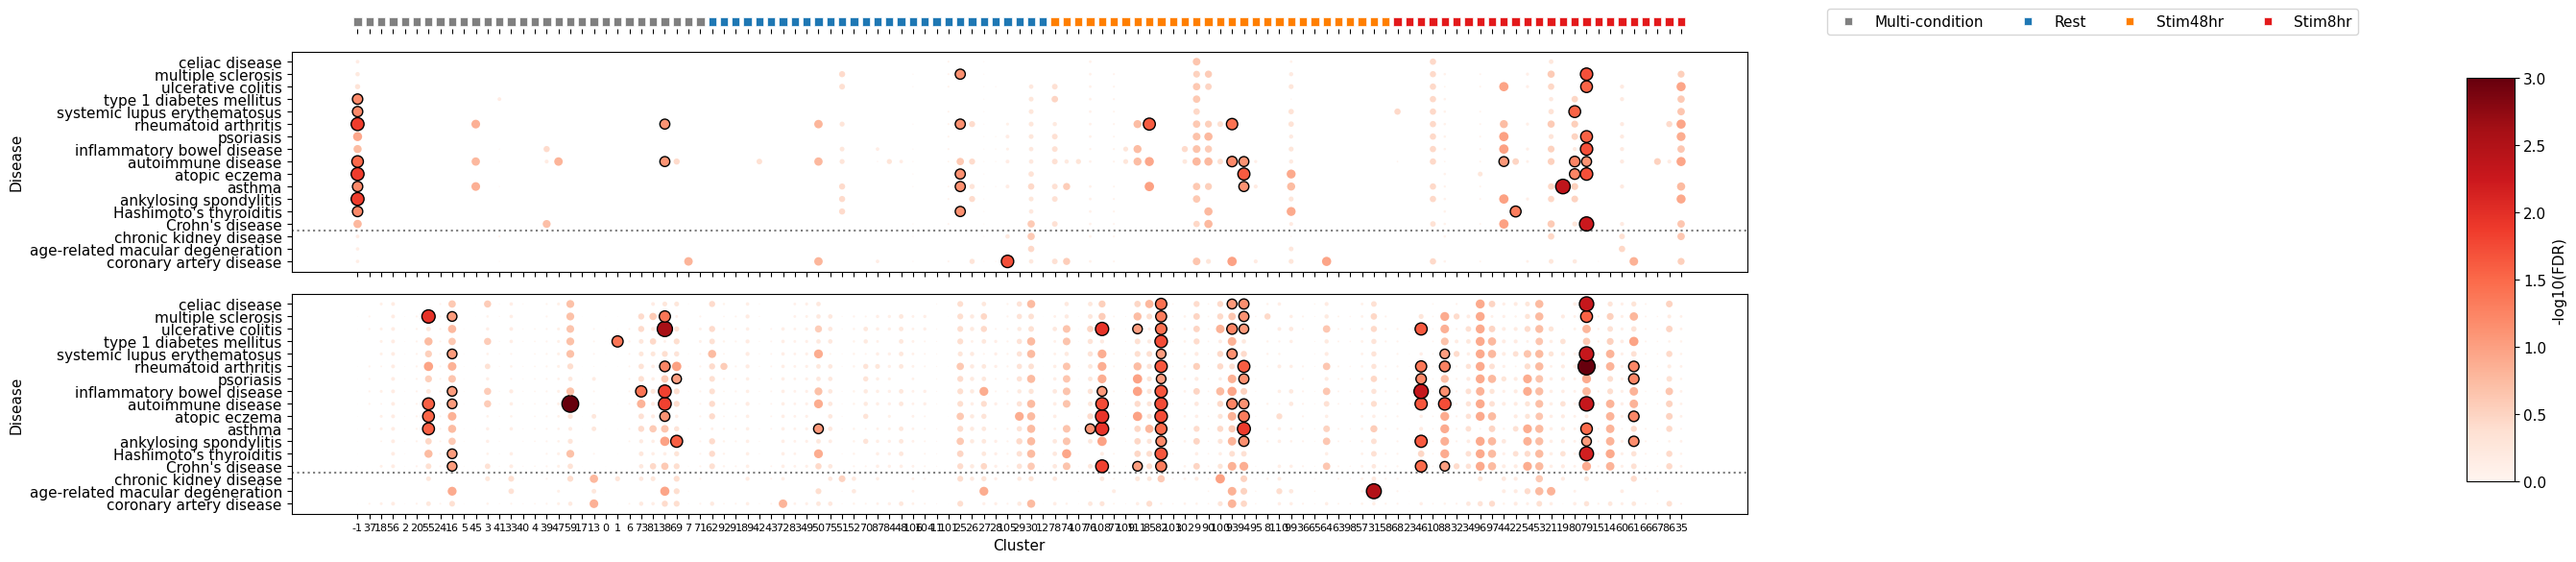

In [80]:
condition_colors = palettes['culture_condition'].copy()
condition_colors['Multi-condition'] = 'grey'

# Create figure with 3 subplots stacked vertically
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(25, 6), 
                                   gridspec_kw={'height_ratios': [0.03, 0.45, 0.45]},
                                   sharex=True)
# plt.subplots_adjust(hspace=0.01)

# Top panel: Condition annotation
g = sns.scatterplot(x=condition_data.set_index('cluster').loc[cl_order].index, y=1, hue=condition_data.set_index('cluster').loc[cl_order]['condition_label'], palette=condition_colors, ax=ax0, marker='s')
ax0.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=len(condition_colors))
ax0.set_frame_on(False)
ax0.grid(False)
# ax0.set_xticks([])
ax0.set_yticks([])

# Middle panel: Upstream enrichment
pl_enrichment_df['log10_p_adj_fdr'] = - np.log10(pl_enrichment_df['p_adj_fdr'])
pl_enrichment_df['signif'] = pl_enrichment_df['log10_p_adj_fdr'] >= 1

# Ensure disease is treated as categorical with proper order and sort
pl_enrichment_df['disease'] = pd.Categorical(pl_enrichment_df['disease'], categories=disease_order, ordered=True)
pl_enrichment_df = pl_enrichment_df.sort_values('disease')

ax1.scatter(x=pl_enrichment_df['cluster'],
           y=pl_enrichment_df['disease'], 
           s=pl_enrichment_df['log10_p_adj_fdr']*50,
           c=pl_enrichment_df['log10_p_adj_fdr'],
           linewidth=np.where(pl_enrichment_df['signif'], 1, 0),
           edgecolor='black',
           cmap='Reds', vmin=0, vmax=3,
           )

# Add dotted line between autoimmune and negative control diseases
ax1.axhline(y=len(neg_ctrl_diseases)-0.5, color='black', linestyle=':', alpha=0.5)

# ax1.set_yticks(range(len(disease_order)))
# ax1.set_yticklabels(disease_order, rotation=0)
ax1.set_ylabel('Disease')

pl_downstream_enrichment_df['log10_p_adj_fdr'] = - np.log10(pl_downstream_enrichment_df['p_adj_fdr'])
pl_downstream_enrichment_df['signif'] = pl_downstream_enrichment_df['log10_p_adj_fdr'] >= 1

# Ensure disease is treated as categorical with proper order and sort
pl_downstream_enrichment_df['disease'] = pd.Categorical(pl_downstream_enrichment_df['disease'], categories=disease_order, ordered=True)
pl_downstream_enrichment_df = pl_downstream_enrichment_df.sort_values('disease')

ax2.scatter(x=pl_downstream_enrichment_df['cluster'],
           y=pl_downstream_enrichment_df['disease'], 
           s=pl_downstream_enrichment_df['log10_p_adj_fdr']*50,
           c=pl_downstream_enrichment_df['log10_p_adj_fdr'],
           linewidth=np.where(pl_downstream_enrichment_df['signif'], 1, 0),
           edgecolor='black',
           cmap='Reds', vmin=0, vmax=3,
           )

# Add dotted line between autoimmune and negative control diseases
ax2.axhline(y=len(neg_ctrl_diseases)-0.5, color='black', linestyle=':', alpha=0.5)

# ax2.set_yticks(range(len(disease_order)))
# ax2.set_yticklabels(disease_order, rotation=0)
ax2.set_ylabel('Disease')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=8)
ax2.set_xlabel('Cluster')

# Add single colorbar at the bottom
norm = plt.Normalize(vmin=0, vmax=3)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
cbar_ax = fig.add_axes([1.03, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax, label='-log10(FDR)')

plt.tight_layout()

In [82]:
enrichment_df[enrichment_df['p_adj_fdr'] < 0.1].sort_values('p_adj_fdr')

,odds_ratio,p_value,ci_low,ci_high,cluster_size,in_cluster_in_disease,in_cluster_not_disease,not_cluster_in_disease,not_cluster_not_disease,intersecting_genes,cluster,disease,p_adj_fdr,gene_set
273,15.089679,0.004294,2.000224,113.843136,6,3,3,123,1863,"[HDAC3, TBL1XR1, NCOR1]",19,asthma,0.004294,regulators
349,28.025571,0.000803,3.686289,213.109750,6,3,3,68,1919,"[BATF, IPMK, STAT3]",79,Crohn's disease,0.005619,regulators
60,2.212070,0.002412,1.272212,3.761886,405,24,381,45,1581,"[UBE2E1, ARRDC4, FOXO1, USP24, IMMP2L, FOSL2, ...",-1,ankylosing spondylitis,0.013669,regulators
62,2.708957,0.001209,1.419291,5.059348,405,19,386,29,1597,"[BATF, GATA3, WNK1, ZBTB1, TRAF6, FOSL2, ID2, ...",-1,atopic eczema,0.013669,regulators
70,1.826651,0.002212,1.205773,2.727207,405,40,365,92,1534,"[UBE2E1, GATA3, ARRDC4, CNOT4, ZEB1, CCDC6, TA...",-1,rheumatoid arthritis,0.013669,regulators
247,3.945490,0.002722,1.523115,9.109554,36,8,28,132,1825,"[HHAT, SFTPC, CCND2, MSL2, OSR1, SUPT4H1, CYP4...",105,coronary artery disease,0.019057,regulators
350,20.956703,0.008012,1.852156,150.468060,6,2,4,46,1941,"[BATF, STAT3]",79,atopic eczema,0.019429,regulators
352,11.703170,0.008327,1.554482,88.112450,6,3,3,156,1831,"[BATF, IPMK, STAT3]",79,inflammatory bowel disease,0.019429,regulators
353,17.465875,0.011199,1.549310,124.829046,6,2,4,55,1932,"[BATF, STAT3]",79,multiple sclerosis,0.019598,regulators
366,20.945910,0.008020,1.851201,150.390616,6,2,4,46,1940,"[ID2, KDM8]",94,atopic eczema,0.024059,regulators


In [116]:
enrichment_df[enrichment_df['cluster'] == '94'].sort_values('p_adj_fdr')

,odds_ratio,p_value,ci_low,ci_high,cluster_size,in_cluster_in_disease,in_cluster_not_disease,not_cluster_in_disease,not_cluster_not_disease,intersecting_genes,cluster,disease,p_adj_fdr,gene_set
366,20.945910,0.008020,1.851201,150.390616,6,2,4,46,1940,"[ID2, KDM8]",94,atopic eczema,0.024059,regulators
365,7.490781,0.050336,0.671490,52.845564,6,2,4,124,1862,"[ID2, KDM8]",94,asthma,0.075504,regulators
367,4.511810,0.077974,0.601841,33.823814,6,3,3,360,1626,"[RBM33, MFSD6, PGS1]",94,autoimmune disease,0.077974,regulators


In [118]:
downstream_enrichment_df[downstream_enrichment_df['cluster'] == '94'].sort_values('p_adj_fdr')
# ['intersecting_genes'].explode().unique()

,odds_ratio,p_value,ci_low,ci_high,cluster_size,in_cluster_in_disease,in_cluster_not_disease,not_cluster_in_disease,not_cluster_not_disease,intersecting_genes,cluster,disease,p_adj_fdr,gene_set
1464,2.781623,0.000769,1.497652,4.873689,98,16,82,272,3879,"[MPHOSPH9, ICOS, IL2RA, CXCR4, IL5, IL4, ANKH,...",94,asthma,0.013069,downstream
1473,2.478726,0.002951,1.310297,4.398528,98,15,83,282,3869,"[IL2RA, ICOS, STAT1, STAT3, UQCC2, PHLDA1, CEM...",94,rheumatoid arthritis,0.025086,downstream
1465,3.318321,0.008212,1.263174,7.388644,98,7,91,94,4057,"[IL2RA, STAT3, IL4, IL3, IL13, SLAMF1, RAD50]",94,atopic eczema,0.046537,downstream
1463,2.643339,0.016552,1.085313,5.585060,98,8,90,135,4016,"[IL2RA, STAT3, PHLDA1, IFNGR2, SH2B3, NARF, SO...",94,ankylosing spondylitis,0.070291,downstream
1467,3.431496,0.020674,1.053241,8.719377,98,5,93,64,4087,"[IL2RA, STAT1, UQCC2, MYO9B, SH2B3]",94,celiac disease,0.070291,downstream
1472,2.322058,0.031199,0.955558,4.891131,98,8,90,153,3998,"[IL2RA, STAT3, IL3, IL13, IFNGR2, SH2B3, RAD50...",94,psoriasis,0.073571,downstream
1466,1.585410,0.034622,0.964712,2.533473,98,26,72,770,3381,"[STAT3, CD80, FYB1, MCL1, IFNG, IL2RA, PHLDA1,...",94,autoimmune disease,0.073571,downstream
1471,2.497320,0.030511,0.956589,5.512070,98,7,91,124,4027,"[IL2RA, CXCR4, STAT3, BCL6, IFNGR2, SH2B3, CD80]",94,multiple sclerosis,0.073571,downstream
1476,2.120035,0.047486,0.873667,4.456941,98,8,90,167,3984,"[IL2RA, STAT3, CD40LG, IFNGR2, SH2B3, FYB1, MN...",94,ulcerative colitis,0.089696,downstream
1460,1.982692,0.078706,0.762457,4.352186,98,7,91,155,3996,"[IL2RA, STAT3, IFNGR2, SH2B3, MCL1, IFNG, LNPEP]",94,Crohn's disease,0.133800,downstream


In [102]:
clustering_df[clustering_df['cluster'] == '93']

,hdbscan,target_contrast_gene_name_corrected,cluster,culture_condition
_index,,,,
ENSG00000159314_Stim48hr,93,ARHGAP27,93,Stim48hr
ENSG00000138768_Stim48hr,93,USO1,93,Stim48hr
ENSG00000105552_Stim48hr,93,BCAT2,93,Stim48hr
ENSG00000197296_Stim48hr,93,FITM2,93,Stim48hr
ENSG00000132846_Stim48hr,93,ZBED3,93,Stim48hr
ENSG00000204406_Stim48hr,93,MBD5,93,Stim48hr
ENSG00000198589_Stim48hr,93,LRBA,93,Stim48hr
ENSG00000109685_Stim48hr,93,NSD2,93,Stim48hr


In [74]:
clustering_df[clustering_df['target_contrast_gene_name_corrected'] == 'COG6']

,hdbscan,target_contrast_gene_name_corrected,cluster,culture_condition
_index,,,,
ENSG00000133103_Rest,30,COG6,30,Rest
ENSG00000133103_Stim8hr,21,COG6,21,Stim8hr
ENSG00000133103_Stim48hr,99,COG6,99,Stim48hr


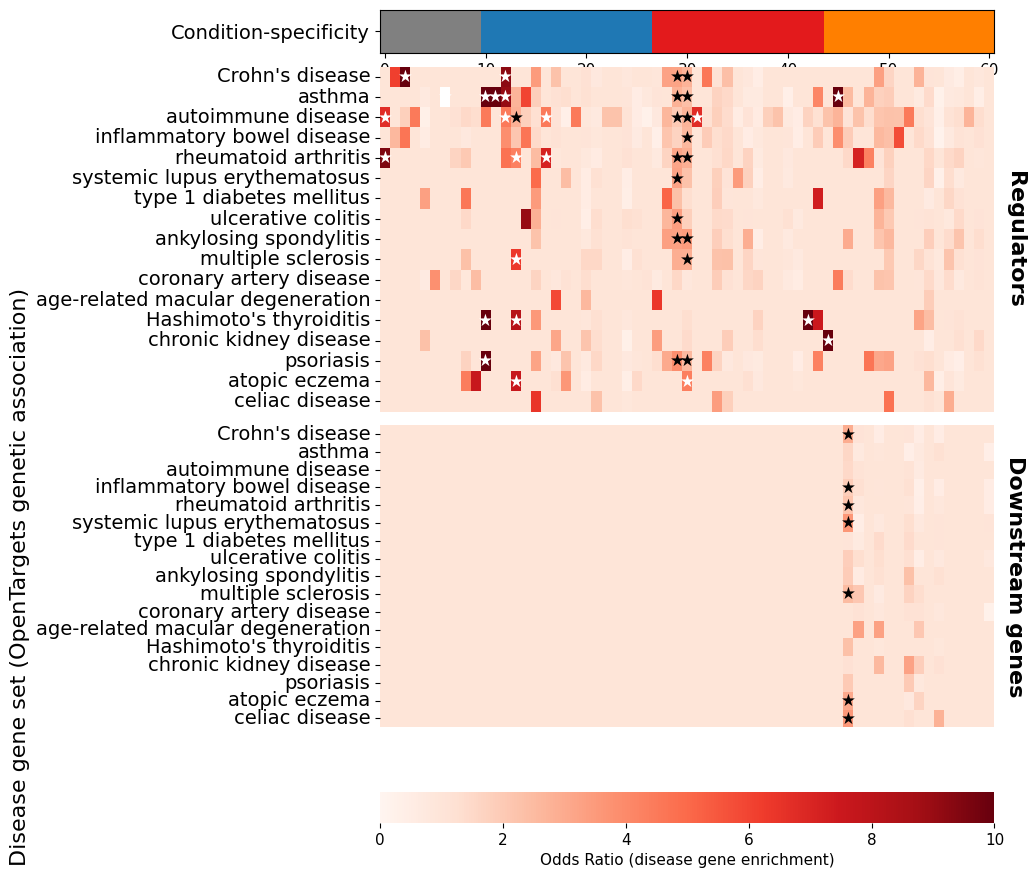

In [653]:
# Create figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(max(5, len(row_order_final) * 0.13), 11), 
                                     gridspec_kw={'height_ratios': [0.1, 0.8, 1], 'hspace': 0.05})

# Create color map for condition labels
condition_label_colors = {
    'Multi-condition': '#808080',  # Gray for multi-condition
    'Rest': condition_colors['Rest'],
    'Stim8hr': condition_colors['Stim8hr'],
    'Stim48hr': condition_colors['Stim48hr']
}

# Map condition labels to colors
condition_colors_mapped = condition_annotation['condition_label'].map(condition_label_colors)

# Top panel: Condition annotation (single row)
from matplotlib.colors import ListedColormap
condition_data = condition_annotation['condition_label'].map({'Multi-condition': 0, 'Rest': 1, 'Stim8hr': 2, 'Stim48hr': 3}).values.reshape(1, -1)
cmap_condition = ListedColormap([condition_label_colors[l] for l in ['Multi-condition', 'Rest', 'Stim8hr', 'Stim48hr']])

im1 = ax1.imshow(condition_data, aspect='auto', cmap=cmap_condition, vmin=0, vmax=3)
ax1.set_yticks([0])
ax1.set_yticklabels(['Condition-specificity'], fontsize=14)
# ax1.set_xticks([])
ax1.set_xlabel('Regulator cluster', fontsize=16)

# Middle panel: Perturbed genes (regulators)
sns.heatmap(heatmap_perturbed_all_sorted.T,
            cmap='Reds',
            annot=False, 
            cbar=False,
            xticklabels=False,
            yticklabels=True,
            ax=ax2,
            vmin=0, vmax=10)

ax2.text(heatmap_perturbed_all_sorted.shape[0] + 1, heatmap_perturbed_all_sorted.shape[1]/2, 'Regulators', 
         rotation=270, fontsize=16, fontweight='bold', va='center')
ax2.set_ylabel('', fontsize=16)
ax2.set_xlabel('', fontsize=18)
ax2.tick_params(axis='y', rotation=0, labelsize=14)

# Bottom panel: Downstream genes
sns.heatmap(heatmap_downstream_all_sorted.T,
            cmap='Reds',
            annot=False, 
            cbar_kws={'label': 'Odds Ratio (disease gene enrichment)', 'orientation': 'horizontal'},
            cbar=True,
            xticklabels=False,
            yticklabels=True,
            ax=ax3,
            vmin=0, vmax=10)

ax3.text(heatmap_downstream_all_sorted.shape[0] + 1, heatmap_downstream_all_sorted.shape[1]/2, 'Downstream genes', 
         rotation=270, fontsize=16, fontweight='bold', va='center')
ax3.set_ylabel('Disease gene set (OpenTargets genetic association)', fontsize=16)
ax3.set_xlabel('', fontsize=18)
ax3.tick_params(axis='y', rotation=0, labelsize=14)

# Add significance indicators for perturbed genes
for i in range(len(heatmap_perturbed_all_sorted.columns)):
    for j in range(len(heatmap_perturbed_all_sorted.index)):
        if sig_fdr_perturbed_all_sorted.T.iloc[i,j]:
            dot_color = 'white' if heatmap_perturbed_all_sorted.T.iloc[i,j] > 4 else 'black'
            ax2.text(j+0.5, i+0.5, '★', ha='center', va='center',
                    color=dot_color, fontsize=12, fontweight='bold')

# Add significance indicators for downstream
for i in range(len(heatmap_downstream_all_sorted.columns)):
    for j in range(len(heatmap_downstream_all_sorted.index)):
        if sig_fdr_downstream_all_sorted.T.iloc[i,j]:
            dot_color = 'white' if heatmap_downstream_all_sorted.T.iloc[i,j] > 4 else 'black'
            ax3.text(j+0.5, i+0.5, '★', ha='center', va='center',
                    color=dot_color, fontsize=12, fontweight='bold')

fig.tight_layout()
plt.savefig("./results/combined_3panel_GWAS_enrichment_all_clusters.pdf", bbox_inches='tight')
plt.savefig("./results/combined_3panel_GWAS_enrichment_all_clusters.png", bbox_inches='tight', dpi=300)
plt.show()

In [603]:
downstream_enrichment_df[downstream_enrichment_df['p_adj_fdr'] < 0.1]

,odds_ratio,p_value,ci_low,ci_high,cluster_size,in_cluster_in_disease,in_cluster_not_disease,not_cluster_in_disease,not_cluster_not_disease,intersecting_genes,cluster,disease,p_adj_fdr,gene_set
243,3.211499,0.001646,1.501860,6.264014,98,11,87,108,2745,"[JAK2, IL12RB2, STMN3, FKBP5, LSP1, GPSM1, CCR...",32,ulcerative colitis,0.024685,downstream
397,2.302628,0.033666,0.940208,4.902073,98,8,90,106,2747,"[ZFP36L1, FASLG, RBPJ, CD200, MAD1L1, RGS14, H...",46,Crohn's disease,0.089775,downstream
401,2.402590,0.005264,1.235164,4.362696,98,14,84,185,2668,"[ZFP36L1, FASLG, CYFIP2, AHI1, NAB2, NAMPT, PD...",46,asthma,0.042112,downstream
402,3.101693,0.012039,1.169544,6.999832,98,7,91,69,2784,"[FASLG, AHI1, NAB2, PDCD1, RGS14, CSF2, IL2RA]",46,atopic eczema,0.045940,downstream
403,1.777457,0.010265,1.092221,2.824139,98,28,70,524,2329,"[ATP8B2, MAD1L1, LAG3, IL2RA, FASLG, RBPJ, PDC...",46,autoimmune disease,0.045940,downstream
410,2.568987,0.014356,1.107641,5.283227,98,9,89,108,2745,"[CD47, FASLG, AHI1, STIM1, IL2RA, CTLA4, ITGAM...",46,systemic lupus erythematosus,0.045940,downstream
411,4.678357,0.000095,2.162008,9.268606,98,11,87,75,2778,"[ZFP36L1, FASLG, SHC4, RBPJ, PRKD2, MAD1L1, PS...",46,type 1 diabetes mellitus,0.001523,downstream
447,2.967130,0.004268,1.336317,5.935272,99,10,89,104,2748,"[APEH, UBAC2, ITGA4, SPRED2, NFKB1, PDK1, BACH...",39,Crohn's disease,0.034147,downstream
451,3.066908,0.012692,1.156757,6.918577,99,7,92,69,2783,"[STAT6, CIART, LEF1, BACH2, BCL2L11, IL18R1, I...",39,atopic eczema,0.050767,downstream
453,3.556004,0.019287,1.073592,9.267829,99,5,94,42,2810,"[SPRED2, ITGA4, PRELID2, BACH2, IL18R1]",39,celiac disease,0.061719,downstream


In [602]:
enrichment_df[enrichment_df['p_adj_fdr'] < 0.1]

,odds_ratio,p_value,ci_low,ci_high,cluster_size,in_cluster_in_disease,in_cluster_not_disease,not_cluster_in_disease,not_cluster_not_disease,intersecting_genes,cluster,disease,p_adj_fdr,gene_set
14,3.213843,0.047596,0.806716,9.372425,39,4,35,67,1886,"[SMAD3, IL12RB2, NFKB1, RASGRP1]",20,Crohn's disease,0.071395,regulators
15,3.316099,0.043545,0.831701,9.682690,39,4,35,65,1888,"[SMAD3, TM2D1, NFKB1, RASGRP1]",20,ankylosing spondylitis,0.071395,regulators
16,2.775093,0.033068,0.932097,6.885026,39,6,33,120,1833,"[SMAD3, CCNC, NFKB1, ICOS, ADAM19, MFHAS1]",20,asthma,0.071395,regulators
17,2.027614,0.038815,0.926217,4.187336,39,12,27,351,1602,"[SMAD3, IL12RB2, CIP2A, C8orf33, CCNC, NFKB1, ...",20,autoimmune disease,0.071395,regulators
21,3.893176,0.014768,1.154094,10.430600,39,5,34,71,1882,"[SMAD3, IL12RB2, NFKB1, RASGRP1, KLHDC10]",20,psoriasis,0.071395,regulators
22,3.195991,0.012309,1.166877,7.566011,39,7,32,125,1828,"[SMAD3, IL12RB2, NFKB1, TM2D1, CACHD1, RASGRP1...",20,rheumatoid arthritis,0.071395,regulators
23,3.264197,0.045545,0.819024,9.525115,39,4,35,66,1887,"[SMAD3, IL12RB2, NFKB1, RASGRP1]",20,systemic lupus erythematosus,0.071395,regulators
25,3.395099,0.024129,1.009910,9.051331,39,5,34,81,1872,"[SMAD3, IL12RB2, C8orf33, NFKB1, RASGRP1]",20,ulcerative colitis,0.071395,regulators
243,6.769582,0.044965,0.772572,81.324221,5,3,2,360,1627,"[PLA2G4A, NDRG1, KLF4]",80,autoimmune disease,0.044965,regulators
252,2.769996,0.031423,0.944635,6.708850,68,6,62,65,1862,"[IL21R, EGR2, RASA2, BATF, IPMK, STAT3]",89,Crohn's disease,0.067336,regulators


In [619]:
downstream_df

NameError: name 'downstream_df' is not defined

In [609]:
clustering_df[clustering_df['target_contrast_gene_name_corrected'] == 'COG6']

,hdbscan,target_contrast_gene_name_corrected,culture_condition,cluster
_index,,,,
ENSG00000133103_Rest,58,COG6,Rest,58
ENSG00000133103_Stim8hr,33,COG6,Stim8hr,33
ENSG00000133103_Stim48hr,111,COG6,Stim48hr,111


In [612]:
clustering_df[clustering_df['hdbscan'] == 33].target_contrast_gene_name_corrected.unique().tolist()

['PLAT',
 'COG5',
 'EML2',
 'USP22',
 'RAC2',
 'CAMSAP1',
 'LCK',
 'RAB19',
 'DCAF11',
 'TMEM205',
 'ACTR2',
 'FAM204A',
 'CDS2',
 'NUDCD1',
 'SYK',
 'CD28',
 'PDS5B',
 'SCAF4',
 'ZNF790',
 'CRIPT',
 'PTPRC',
 'ATXN7L3',
 'UBL7',
 'PPP1R15B',
 'CSH1',
 'BCL10',
 'BRPF1',
 'ATP2A3',
 'PPP3R1',
 'WAS',
 'AIRIM',
 'TMX1',
 'SLC3A2',
 'IKZF1',
 'PIGB',
 'SPTLC2',
 'RANBP3',
 'CBLL1',
 'PHF19',
 'SRP9',
 'DIPK1A',
 'ABCC1',
 'SHOC2',
 'FLVCR2',
 'UBE2E2',
 'EIF4G2',
 'LRBA',
 'VPS41',
 'KIF16B',
 'SLC7A6',
 'ZSCAN23',
 'UHRF1',
 'RAVER1',
 'TASOR',
 'SRP14',
 'ZFP82',
 'ARID4B',
 'ING5',
 'PDIA3',
 'KCTD21',
 'HACD4',
 'DZIP1',
 'ANKRD61',
 'MCFD2',
 'HSD17B12',
 'CALCOCO2',
 'TBC1D31',
 'KAT6A',
 'ELP6',
 'TLN1',
 'SNAP29',
 'DDX60L',
 'TBX22',
 'ARPC2',
 'TTYH3',
 'YIPF1',
 'FITM2',
 'CDIPT',
 'ARPC3',
 'ABHD17A',
 'NCBP3',
 'PGGT1B',
 'HELT',
 'ARF4',
 'TTC7A',
 'COP1',
 'PPP1R10',
 'CYB5R4',
 'SPATA33',
 'KPNA4',
 'MTA3',
 'CYB561D2',
 'PEX5',
 'DCAF5',
 'TSC1',
 'ITK',
 'DEF6',
 'APPL2

In [606]:
[x['intersecting_genes'] for i,x in enrichment_df[enrichment_df['p_adj_fdr'] < 0.1].iterrows() if 'CACHD1' in x['intersecting_genes']]

[['SMAD3',
  'IL12RB2',
  'CIP2A',
  'C8orf33',
  'CCNC',
  'NFKB1',
  'TM2D1',
  'SLAMF7',
  'CACHD1',
  'IFI30',
  'RASGRP1',
  'ICOS'],
 ['SMAD3', 'IL12RB2', 'NFKB1', 'TM2D1', 'CACHD1', 'RASGRP1', 'ICOS']]

### Forest plot for individual cluster

In [107]:
def plot_cluster_forest(cluster_id):
    """
    Plot forest plots showing odds ratios for a specific cluster across all diseases.
    Creates three subplots: Perturbed genes, Top 100 Downstream, Bottom 100 Downstream.
    
    Parameters:
    -----------
    cluster_id : int
        The cluster ID to plot
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get data for this cluster
    cluster_perturbed = enrichment_df[enrichment_df['cluster'] == cluster_id]
    cluster_top = downstream_top_enrichment_df[downstream_top_enrichment_df['cluster'] == cluster_id]
    cluster_bottom = downstream_bottom_enrichment_df[downstream_bottom_enrichment_df['cluster'] == cluster_id]
    
    if len(cluster_perturbed) == 0 and len(cluster_top) == 0 and len(cluster_bottom) == 0:
        print(f"No data found for cluster {cluster_id}")
        return
    
    # Get all diseases and sort them by name
    all_diseases_in_data = sorted(set(cluster_perturbed['disease'].unique()) | 
                                set(cluster_top['disease'].unique()) | 
                                set(cluster_bottom['disease'].unique()))
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, max(6, len(all_diseases_in_data) * 0.2)),
                                        gridspec_kw={'wspace': 0.05}, sharey=True)
    
    # Helper function to plot forest plot
    def plot_forest(ax, data, title, label_col='disease_gene'):
        # Create dataframe with all diseases in same order
        plot_data = []
        for disease in all_diseases_in_data:
            disease_data = data[data['disease'] == disease]
            if len(disease_data) > 0:
                row = disease_data.iloc[0]
                plot_data.append({
                    'disease': disease,
                    'odds_ratio': row['odds_ratio'],
                    'ci_lower': row['odds_ratio_ci_lower'],
                    'ci_upper': row['odds_ratio_ci_upper'],
                    'p_value': row['p_value'],
                    'p_adj_fdr': row['p_adj_fdr'],
                    'count': row[f'{label_col}_count']
                })
            else:
                plot_data.append({
                    'disease': disease,
                    'odds_ratio': 1.0,
                    'ci_lower': 1.0,
                    'ci_upper': 1.0,
                    'p_value': 1.0,
                    'p_adj_fdr': 1.0,
                    'count': 0
                })
        
        plot_df = pd.DataFrame(plot_data)
        
        # Plot
        y_pos = np.arange(len(plot_df))
        
        # Color by significance (only red for nominal significance)
        colors = ['#e31a1c' if row['p_value'] < 0.05 else '#969696' for _, row in plot_df.iterrows()]
        
        # Plot error bars with colors matching points
        for i, (_, row) in enumerate(plot_df.iterrows()):
            color = '#e31a1c' if row['p_value'] < 0.05 else '#969696'
            ax.errorbar(row['odds_ratio'], i,
                       xerr=[[row['odds_ratio'] - row['ci_lower']], 
                            [row['ci_upper'] - row['odds_ratio']]],
                       fmt='o', color=color, ecolor=color, 
                       elinewidth=1, capsize=0, markersize=8,
                       markeredgecolor='black', markeredgewidth=0.5)
        
        # Add vertical line at OR=1
        ax.axvline(x=1, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Formatting
        ax.set_yticks(y_pos)
        ax.set_yticklabels(plot_df['disease'], fontsize=12)
        ax.set_xlabel('Odds Ratio', fontsize=14)
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        
        # Set x-axis to log scale
        ax.set_xscale('log')
        ax.set_xlim(0.1, max(10, plot_df['ci_upper'].max() * 1.2))
        
        # Add gene counts inside plot area, but only for significant tests
        for i, (idx, row) in enumerate(plot_df.iterrows()):
            if row['p_value'] < 0.05:
                count = int(row['count'])
                ax.text(0.12, i, f'n={count}', ha='left', va='center',
                       fontsize=11)
        return plot_df
    
    # Plot each panel
    plot_forest(ax1, cluster_perturbed, 'Perturbed Genes', 'disease_gene')
    plot_forest(ax2, cluster_top, 'Top 100 Downstream', 'disease_gene')
    plot_forest(ax3, cluster_bottom, 'Bottom 100 Downstream', 'disease_gene')
    
    # Get cluster annotation
    cluster_info = clustering_df[clustering_df['cluster'] == cluster_id]
    if len(cluster_info) > 0 and 'cluster_label' in clustering_df.columns:
        cluster_label = cluster_info.iloc[0]['cluster_label']
    else:
        cluster_label = f"Cluster {cluster_id}"
    
    # Overall title
    fig.suptitle(f'GWAS Enrichment for {cluster_label}', 
                fontsize=18, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


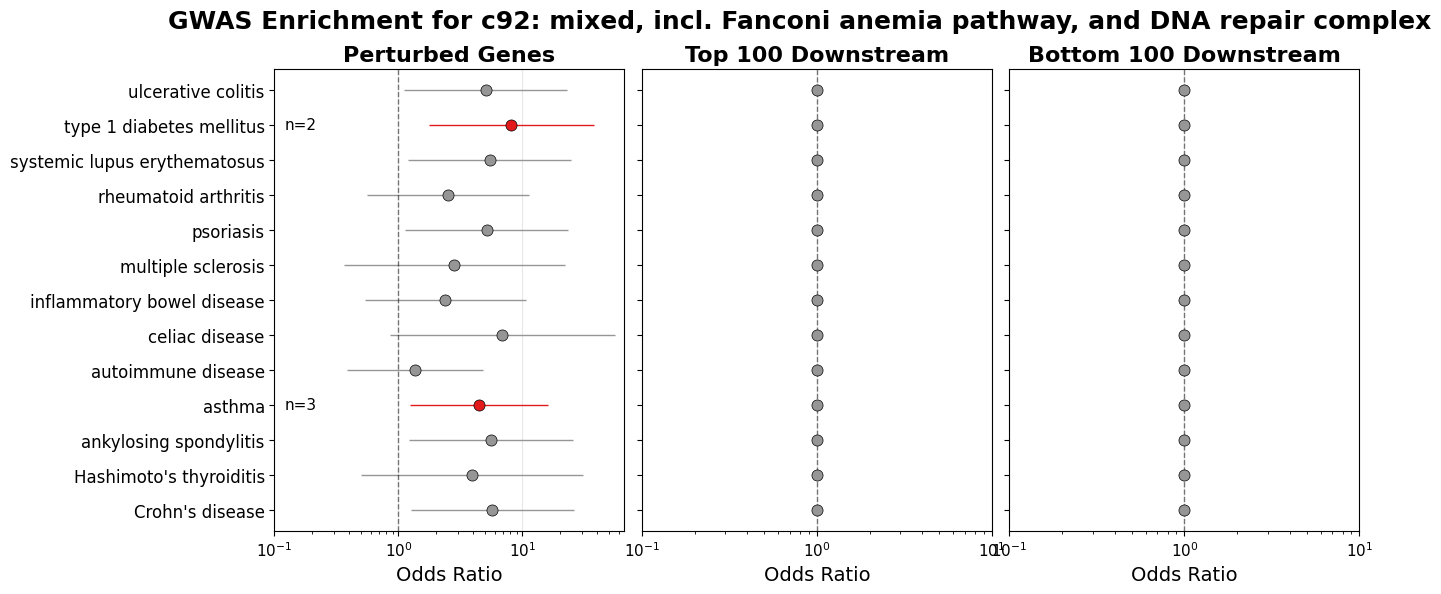

In [135]:
# Example usage - plot forest plot for a specific cluster
plot_cluster_forest(92)


In [197]:
clustering_df[clustering_df['cluster_member'].apply(lambda x: 'CACHD1' in x)]

,Unnamed: 0,cluster,complex_corum_reg,overlap_genes_corum_reg,overlap_fraction_corum_reg,raw_p_value_corum_reg,complex_size_corum_reg,overlap_size_corum_reg,cluster_size_corum_reg,complex_stringdb_reg,...,cluster_gene_size_downstream,cluster_member_downstream,related_cluster_downstream,rest_count,stim8hr_count,stim48hr_count,cluster_member_with_condition,cluster_member,downstream_member,cluster_label
24,24,39,FOSB-JUND-SMAD3-SMAD4 complex,"['JUND', 'SMAD3']",0.066667,0.000942,4.0,2.0,30.0,CL:22847,...,30,"{'CBX3', 'E2F3', 'FKBP5', 'HPCAL1', 'ETS1', 'N...",NaN,0.0,30.0,0.0,"['PXMP4_Stim8hr', 'EXTL2_Stim8hr', 'CABP5_Stim...","{ADAM19, RAB11FIP1, CIP2A, ALKBH2, WRN, PXMP4,...","{TPRKB, HCFC1, CERS6, CDC73, HPCAL1, MAP3K21, ...",c39: FOSB JUND SMAD3 SMAD4 complex
58,58,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8,"{'PCNA', 'FKBP5', 'SLC26A11', 'NPM3', 'PAM16',...",{92},8.0,0.0,0.0,"['HSD17B13_Rest', 'CACHD1_Rest', 'NPIPA7_Rest'...","{CACHD1, IL12RB2, STK25, NPIPA7, HSD17B13, ZNF...","{PNPO, PAM16, PDIA5, CD53, CDC42EP3, ZNRF1, AN...",Cluster 88


In [203]:
enrichment_df[enrichment_df.cluster == 39]

,cluster,cluster_size,disease_gene_count,disease_gene_genes,odds_ratio,odds_ratio_ci_lower,odds_ratio_ci_upper,p_value,enrichment_fold,disease,p_adj_fdr,cluster_label,cluster_annotation
21,39,30,3,"['RASGRP1', 'IL12RB2', 'SMAD3']",4.540541,1.318434,15.637116,0.038094,3.947500,Crohn's disease,0.452449,Cluster 39,Cluster 39
24,39,30,3,"['RASGRP1', 'IL12RB2', 'SMAD3']",4.301994,1.251861,14.783720,0.043152,3.759524,systemic lupus erythematosus,0.452449,Cluster 39,Cluster 39
29,39,30,3,"['RASGRP1', 'IL12RB2', 'SMAD3']",4.086721,1.191534,14.016628,0.048533,3.588636,psoriasis,0.452449,Cluster 39,Cluster 39
34,39,30,3,"['RASGRP1', 'IL12RB2', 'SMAD3']",3.986772,1.163445,13.661461,0.051344,3.508889,ulcerative colitis,0.452449,Cluster 39,Cluster 39
42,39,30,8,"['CACHD1', 'JUND', 'RASGRP1', 'IL12RB2', 'EXTL...",2.162250,0.950850,4.916998,0.059984,1.822799,autoimmune disease,0.452449,Cluster 39,Cluster 39
65,39,30,4,"['RASGRP1', 'IL12RB2', 'SMAD3', 'CACHD1']",2.752345,0.938498,8.071840,0.076176,2.448062,rheumatoid arthritis,0.453873,Cluster 39,Cluster 39
73,39,30,2,"['JUND', 'RASGRP1']",4.354286,0.983288,19.282043,0.091355,3.898765,Hashimoto's thyroiditis,0.487419,Cluster 39,Cluster 39
81,39,30,2,"['RASGRP1', 'SMAD3']",4.026455,0.912745,17.762180,0.103252,3.629885,type 1 diabetes mellitus,0.489307,Cluster 39,Cluster 39
108,39,30,2,"['SLAMF7', 'EXTL2']",3.089796,0.708158,13.481225,0.154489,2.845045,multiple sclerosis,0.543139,Cluster 39,Cluster 39
129,39,30,2,"['RASGRP1', 'SMAD3']",2.765568,0.636276,12.020523,0.181726,2.567480,ankylosing spondylitis,0.551245,Cluster 39,Cluster 39


In [202]:
enrichment_df[enrichment_df.cluster == 37]['disease_gene_genes'][3]

"['ITK', 'TASOR', 'ARID4B', 'ACO2', 'PTPRC', 'ARHGAP27', 'COG6', 'MBD2', 'UBE2E2', 'CD247', 'CD28', 'ZFYVE26', 'KAT6A']"

In [ ]:
downstream = pd.read_csv('/mnt/oak/users/emma/data/GWT//CD4i_final/nde50ntotal100_varfiltered_clustering_downstream_genes.csv')

In [25]:
downstream[(downstream.hdbscan_cluster==66) ].sort_values('zscore_rank_positive_regulation')[0:20]

,Unnamed: 0,hdbscan_cluster,downstream_gene,num_of_upstream,sign_coherence,zscore_rank_negative_regulation,zscore_rank_positive_regulation
13638,3641,66,CITED2,28,1.0,5274,1
10687,690,66,CMTM6,26,1.0,5273,2
14401,4404,66,SPTY2D1,22,1.0,5272,3
10998,1001,66,RIPK2,23,1.0,5271,4
12307,2310,66,RAB33A,24,1.0,5270,5
13569,3572,66,PTPN13,26,1.0,5269,6
13090,3093,66,NR3C2,20,1.0,5268,7
10385,388,66,RORA,24,1.0,5267,8
10281,284,66,ATP2B4,18,1.0,5266,9
10983,986,66,CTSH,20,1.0,5265,10


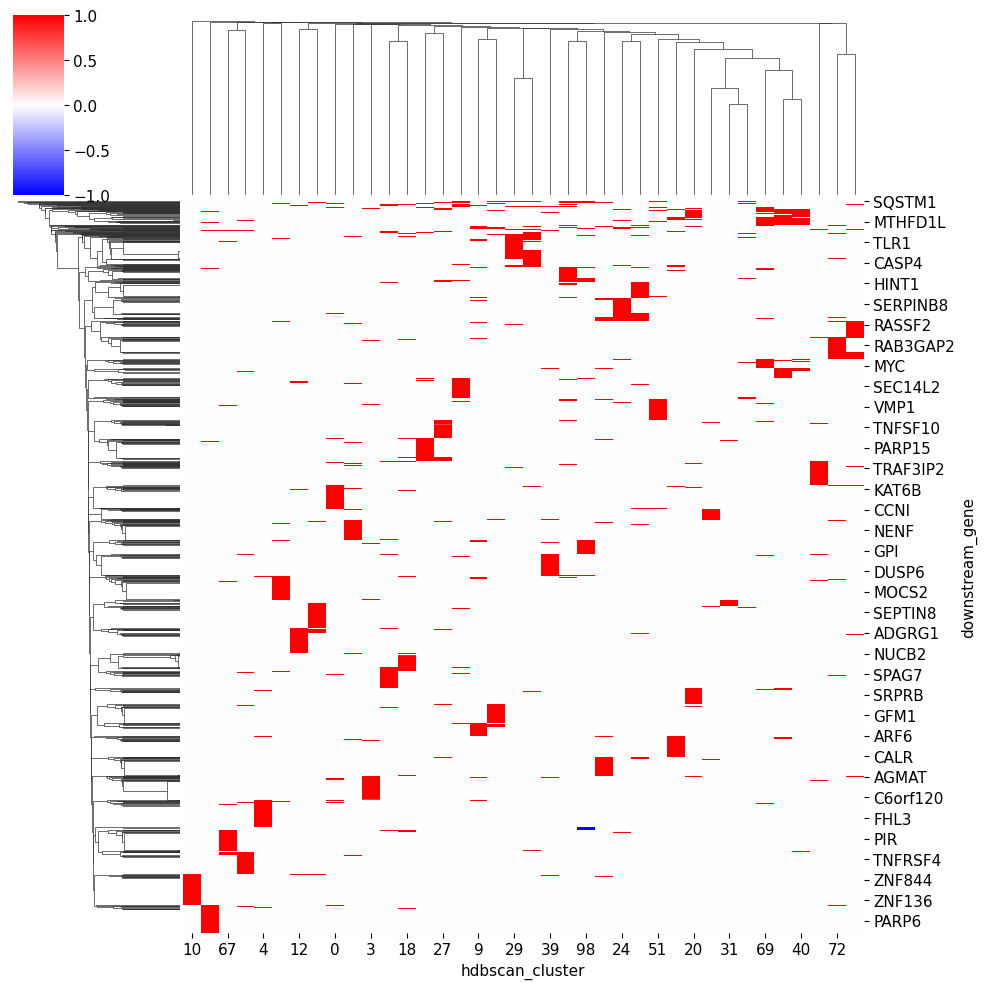

In [31]:
pl_df = downstream_bottom_df.pivot(index='downstream_gene', columns='hdbscan_cluster', values='sign_coherence').fillna(0)
sns.clustermap(pl_df, cmap='bwr')

In [241]:
for cluster_id in [46,32, 66, 85]:
    print(f"\nCluster {cluster_id}")
    print("-" * 20)
    # Get disease genes from top enrichment
    top_cluster_data = downstream_top_enrichment_df[downstream_top_enrichment_df.cluster == cluster_id]
    top_genes = set()
    for _, row in top_cluster_data.iterrows():
        genes = eval(row['disease_gene_genes']) if isinstance(row['disease_gene_genes'], str) else row['disease_gene_genes']
        top_genes.update(genes)
    print("Disease genes from top enrichment:")
    
    # Display top genes across multiple rows
    top_genes_sorted = sorted(top_genes)
    genes_per_row = 5
    for i in range(0, len(top_genes_sorted), genes_per_row):
        print(", ".join(top_genes_sorted[i:i+genes_per_row]))
    
    # Get disease genes from bottom enrichment  
    bottom_cluster_data = downstream_bottom_enrichment_df[downstream_bottom_enrichment_df.cluster == cluster_id]
    bottom_genes = set()
    for _, row in bottom_cluster_data.iterrows():
        genes = eval(row['disease_gene_genes']) if isinstance(row['disease_gene_genes'], str) else row['disease_gene_genes']
        bottom_genes.update(genes)
    print("\nDisease genes from bottom enrichment:")
    
    # Display bottom genes across multiple rows
    bottom_genes_sorted = sorted(bottom_genes)
    for i in range(0, len(bottom_genes_sorted), genes_per_row):
        print(", ".join(bottom_genes_sorted[i:i+genes_per_row]))
    print()


Cluster 46
--------------------
Disease genes from top enrichment:
ADAP1, AGK, BMP2K, CD2, CHST2
EGR2, FARP1, FYN, GNG4, ITPKB
KIAA0930, LBH, LRBA, LYST, NCOA1
NFATC1, NR3C1, P4HA2, PAM, PDE7B
PRAG1, PTPN11, RASSF4, RBPJ, RCAN1
RIN3, RNF19A, TBC1D4, TIMMDC1, TNFSF4
ZC3H12C, ZNF704

Disease genes from bottom enrichment:
AHI1, CD109, CD200, CSF2, CTLA4
EDARADD, FASLG, HDAC7, IL2RA, LAG3
NAMPT, PDCD1, PHLDA1, POU2AF1, SHC4
ZFP36L1


Cluster 32
--------------------
Disease genes from top enrichment:
CD28, CD69, DIPK1A, DPP4, F5
FKBP5, FYB1, FYN, GNG2, GRAP2
ICOS, IL12RB2, IL21R, IL23A, IL7R
ITK, ITM2A, JAK2, LEF1, MAP3K1
MBNL1, PDK1, PRR11, PTPN22, RASSF3
SATB1, SELL, SRPK1, STAT5A, STAT5B
TMEM131L, TNFAIP8, TXK

Disease genes from bottom enrichment:
ABCB1, AGPAT2, AHI1, APOBR, ARHGEF10
CCR1, CHST11, CKAP4, DOCK5, DPF3
GADD45G, GPSM1, GSE1, HELZ2, IER5L
INSR, LAT2, LSP1, MAML3, NCF4
PLD3, PRKCZ, PTEN, SEPTIN8, TYMP
ZDHHC14, ZFP36L1, ZMIZ1


Cluster 66
--------------------
Disease genes fr

In [261]:
print(clustering_df[clustering_df['cluster'] == 66].iloc[0])
clustering_df[clustering_df['cluster'] == 66].iloc[0]['cluster_member']

Unnamed: 0                                                                      39
cluster                                                                         66
complex_corum                                        CDK8-CyclinC-Mediator complex
overlap_genes_corum                                                       ['CCNC']
overlap_fraction_corum                                                    0.027778
raw_p_value_corum                                                           0.0364
complex_size_corum                                                             2.0
complex_stringdb                                                          CL:22847
overlap_genes_stringdb                                         ['PDLIM2', 'CABP5']
overlap_fraction_stringdb                                                 0.055556
raw_p_value_stringdb                                                        0.0603
complex_size_stringdb                                                           22
best

['KLHDC10',
 'ICOS',
 'PXMP4',
 'ZNF641',
 'HPF1',
 'CABP5',
 'C8orf33',
 'RAB11FIP1',
 'IFI30',
 'IL12RB2',
 'ADAM19',
 'AK3',
 'LZTS1',
 'ZNF92',
 'PLA2G4A',
 'PROX2',
 'SLAMF7',
 'PDLIM2',
 'SMAD3',
 'ZNF99',
 'GNG11',
 'RASGRP1',
 'PIGN',
 'ARMC8',
 'ALKBH2',
 'CCNC',
 'HMGN5',
 'HDHD3',
 'CACHD1',
 'AKAP10',
 'MFHAS1',
 'TM2D1',
 'CIP2A',
 'LTB4R',
 'NIPBL',
 'HSD17B13']

## Follow-up analysis on specific clusters

Load perturb-seq results

In [206]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/CD4i_final.merged_DE_results.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50

# Filter very lowly expressed genes
base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

# Calculate for Rest condition
base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

# Calculate for Stim8hr condition
base_mean_stim8 = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim8.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim8.std(1).fillna(10000)

# Calculate for Stim48hr condition
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T
adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

# Exclude from analysis genes with very low base mean (messing up reliability estimate)
gs_mask = (adata_de.var['mean_baseMean_Rest'] > 0.1) & (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1)
adata_de = adata_de[:, gs_mask].copy()
sum(~gs_mask)

3677

In [26]:
tr_results

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name,log_pval
0,AKAP2_Rest,ENSG00000211751,0.244604,0.595480,0.999827,False,TRBC1,Rest,AKAP2,AKAP2,7.519076e-05
1,AKAP2_Stim48hr,ENSG00000211751,0.566390,1.349835,0.999999,False,TRBC1,Stim48hr,AKAP2,AKAP2,2.692196e-07
2,AKAP2_Stim8hr,ENSG00000211751,0.393938,0.953830,1.000000,False,TRBC1,Stim8hr,AKAP2,AKAP2,1.437355e-08
3,ENSG00000000003_Rest,ENSG00000211751,-0.257768,-0.587712,0.999953,False,TRBC1,Rest,ENSG00000000003,TSPAN6,2.050838e-05
4,ENSG00000000003_Stim48hr,ENSG00000211751,-0.241590,-0.535934,0.999804,False,TRBC1,Stim48hr,ENSG00000000003,TSPAN6,8.527307e-05
...,...,...,...,...,...,...,...,...,...,...,...
33981,SMIM11B_Stim48hr,ENSG00000211751,-0.222691,-0.495570,0.999993,False,TRBC1,Stim48hr,SMIM11B,SMIM11B,3.228079e-06
33982,SMIM11B_Stim8hr,ENSG00000211751,0.084704,0.190330,0.999999,False,TRBC1,Stim8hr,SMIM11B,SMIM11B,4.713385e-07
33983,U2AF1L5_Rest,ENSG00000211751,0.458651,0.675268,1.000000,False,TRBC1,Rest,U2AF1L5,U2AF1L5,1.961464e-07
33984,U2AF1L5_Stim48hr,ENSG00000211751,0.332549,0.619601,0.999998,False,TRBC1,Stim48hr,U2AF1L5,U2AF1L5,9.093987e-07


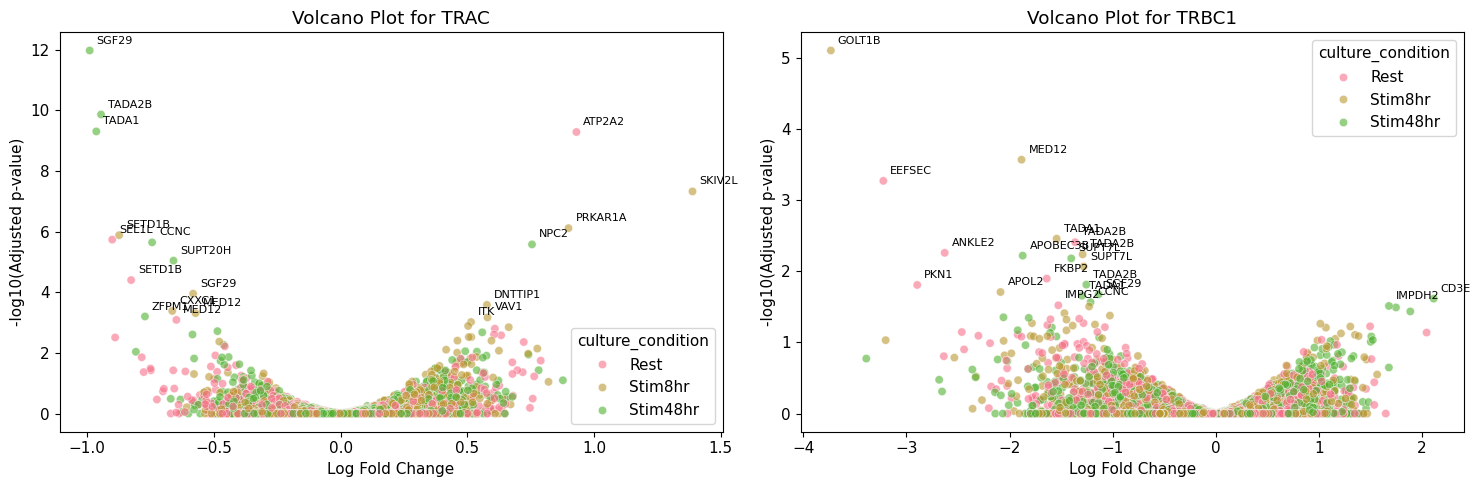

In [30]:
# Create volcano plots for TRAC and TRBC1
genes = ['TRAC', 'TRBC1']
fig, axes = plt.subplots(1, len(genes), figsize=(15, 5))

for i, gene in enumerate(genes):
    tr_results = get_DE_results_long(adata_de, genes=[gene])
    tr_results['log_pval'] = -np.log10(tr_results['adj_p_value'])
    
    # Identify top hits (e.g., top 10 most significant genes)
    top_hits = tr_results.nlargest(20, 'log_pval')
    
    # Create volcano plot with color by culture condition
    sns.scatterplot(data=tr_results, x='log_fc', y='log_pval', hue='culture_condition', ax=axes[i], alpha=0.6)
    
    # # Highlight and label top hits
    # axes[i].scatter(top_hits['log_fc'], top_hits['log_pval'], color='red', s=100)
    
    for _, row in top_hits.iterrows():
        axes[i].annotate(row['target_contrast_gene_name'], 
                         (row['log_fc'], row['log_pval']), 
                         xytext=(5, 5), 
                         textcoords='offset points', 
                         fontsize=8)
    
    axes[i].set_title(f'Volcano Plot for {gene}')
    axes[i].set_xlabel('Log Fold Change')
    axes[i].set_ylabel('-log10(Adjusted p-value)')

plt.tight_layout()

In [160]:
adata_de.var_names = adata_de.var['gene_name'].values

In [161]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats.head()

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000012963,UBR7,Stim8hr,491.0,0,2,2,-12.952742,True,43.169196,True,2-10 DE genes,on-target KD
1,ENSG00000017260,ATP2C1,Stim8hr,469.0,0,1,1,-16.307246,True,102.399025,False,1 DE gene,on-target KD
2,ENSG00000067606,PRKCZ,Stim8hr,427.0,1,1,2,-1.658755,False,0.965897,False,2-10 DE genes,no on-target KD
3,ENSG00000092929,UNC13D,Stim8hr,830.0,0,2,2,-19.259466,True,60.904483,False,2-10 DE genes,on-target KD
4,ENSG00000100504,PYGL,Stim8hr,414.0,1,0,1,0.000000,False,NaN,False,1 DE gene,no on-target KD


In [162]:
disease_gs = disease_gene_df['gene_symbol'].unique()
disease_de_stats = de_stats[de_stats.target_name.isin(disease_gs)].copy()
# Count genes with on-target KD in at least one condition
genes_with_ontarget = disease_de_stats[disease_de_stats['ontarget_effect_category'] == 'on-target KD']['target_name'].unique()
print(f"Number of genes with on-target KD in at least one condition: {len(genes_with_ontarget)}/{len(disease_gs)}")

Number of genes with on-target KD in at least one condition: 1395/3200


In [163]:
disease_de_stats[disease_de_stats['ontarget_effect_category'] == 'on-target KD'].value_counts(['n_total_genes_category', 'condition'])

n_total_genes_category  condition
2-10 DE genes           Stim48hr     577
                        Stim8hr      564
                        Rest         539
>10 DE genes            Stim8hr      413
                        Rest         371
                        Stim48hr     366
1 DE gene               Stim48hr     292
                        Rest         288
                        Stim8hr      281
Name: count, dtype: int64

In [164]:
### PLOT THIS ON LESS GENES ###

# for d in  disease_gene_df.disease_name.unique():
#     if d != 'autoimmune disease':
#         disease_gs = disease_gene_df[disease_gene_df['disease_name'] == d]['gene_symbol'].unique()
#         disease_de_stats = de_stats[de_stats.target_name.isin(disease_gs)].copy()

#         # Sort targets by mean number of DE genes across conditions
#         target_order = disease_de_stats.groupby('target_name')['n_total_de_genes'].mean().sort_values().index

#         # Define condition order and colors
#         condition_order = ['Rest', 'Stim8hr', 'Stim48hr']

#         # Create figure with two subplots
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(len(disease_de_stats.target_name.unique())*0.2, 9), height_ratios=[1, 2], sharex=True)

#         ## Top subplot: N cells barplot ##
#         sns.barplot(
#             data=disease_de_stats,
#             x='target_name', y='n_cells_target',
#             order=target_order,
#             color='lightgrey',
#             ax=ax1
#         )
#         ax1.set_yscale('log')
#         ax1.set_ylabel('# perturbed cells', fontsize=14)
#         ax1.tick_params(axis='y', labelsize=12)

#         ## Bottom subplot: N DE genes barplot ##
#         sns.barplot(
#             data=disease_de_stats,
#             x='target_name', 
#             y='n_total_de_genes',
#             hue='condition',
#             hue_order=condition_order,
#             order=target_order,
#             palette=palettes['culture_condition'],
#             ax=ax2
#         )

#         # Plot points for significant targets
#         points_data = disease_de_stats[disease_de_stats['ontarget_significant']].copy()
#         points_data['n_total_de_genes'] = points_data['n_total_de_genes'] * 1.1  # Offset by 10%

#         sns.stripplot(
#             data=points_data,
#             x='target_name', 
#             y='n_total_de_genes',
#             hue='condition',
#             dodge=True,
#             hue_order=condition_order,
#             order=target_order,
#             color='black',
#             size=3,
#             jitter=True,
#             zorder=10,
#             legend=False,
#             ax=ax2
#         )

#         ax2.set_yscale('log')
#         ax2.set_xlabel(f'{d} GWAS genes (Open Targets)', fontsize=14)
#         ax2.set_ylabel('# Significant DE genes (10% FDR)', fontsize=14)
#         ax2.tick_params(axis='x', rotation=90, labelsize=12)
#         ax2.tick_params(axis='y', labelsize=12)
#         ax2.legend(fontsize=12)
#         plt.tight_layout()


## TCR signalling cluster - cluster 37

In [188]:
cl_id = 37
cl_members = clustering_df[clustering_df['cluster'] == cl_id]['cluster_member'].iloc[0]

# Get results for disease-associated genes
res_df = get_DE_results_long(
    adata_de, 
    targets=cl_members
    )
res_df = res_df[res_df['culture_condition'] == condition_annotation.loc[cl_id][0]].copy()

down_genes = clustering_df[clustering_df['cluster'] == cl_id]['downstream_member'].iloc[0]
down_genes = list(down_genes)

In [189]:
res_df.head()

,index,gene,log_fc,zscore,adj_p_value,significant,gene_name,culture_condition,target_contrast,target_contrast_gene_name
20564,ENSG00000008441_Stim8hr,AAAS,-0.063214,-0.714409,0.873961,False,AAAS,Stim8hr,ENSG00000008441,NFIX
20565,ENSG00000008441_Stim8hr,AACS,0.225347,1.204316,0.732020,False,AACS,Stim8hr,ENSG00000008441,NFIX
20566,ENSG00000008441_Stim8hr,AAGAB,-0.031515,-0.429456,0.937669,False,AAGAB,Stim8hr,ENSG00000008441,NFIX
20567,ENSG00000008441_Stim8hr,AAK1,0.105482,1.260875,0.713369,False,AAK1,Stim8hr,ENSG00000008441,NFIX
20568,ENSG00000008441_Stim8hr,AAMDC,0.373277,1.030079,NaN,False,AAMDC,Stim8hr,ENSG00000008441,NFIX


In [171]:
# # Get all disease genes for cluster 101
# disease_targets = set()
# for genes in enrichment_df[enrichment_df.cluster == cl_id]['disease_gene_genes']:
#     disease_targets.update(eval(genes))
# disease_targets = sorted(list(disease_targets))


# disease_genes = set()
# for genes in downstream_top_enrichment_df[downstream_top_enrichment_df.cluster == cl_id]['disease_gene_genes']:
#     disease_genes.update(eval(genes))
# disease_genes = sorted(list(disease_genes))

# # Create pivot table for heatmap showing only disease genes
# heatmap_data = res_df[res_df.gene.isin(disease_genes) & res_df.target_contrast_gene_name.isin(disease_targets)].pivot(
#     index='target_contrast_gene_name',
#     columns='gene', 
#     values='log_fc'
# )
# # Plot heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(
#     heatmap_data,
#     cmap='RdBu_r', 
#     center=0,
#     vmin=-2,
#     vmax=2,
#     cbar_kws={'label': 'Log2 Fold Change'},
#     xticklabels=True,
#     yticklabels=True
# )
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Target Genes', fontsize=12)
# plt.ylabel('Perturbed Genes', fontsize=12)
# plt.title('Disease Genes Heatmap')
# plt.tight_layout()
# plt.show()

In [ ]:
# print_enrichment_summary(enrichment_df[(enrichment_df['disease'] == 'asthma') & (enrichment_df['cluster'] == cl_id)].iloc[0], clustering_df)

NameError: name 'print_enrichment_summary' is not defined

In [172]:
res_df['signif_up'] = np.where(res_df['significant'] & (res_df['zscore'] > 0), res_df['zscore'], 0)
res_df['signif_down'] = np.where(res_df['significant'] & (res_df['zscore'] < 0), res_df['zscore'], 0)

top_up_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_up').mean(1).sort_values(ascending=False)[0:50].index.tolist()
top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').mean(1).sort_values(ascending=True)[0:50].index.tolist()
# [0:60].index.tolist()
# top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').sum(1).sort_values(ascending=False)[0:60].index.tolist()

print("Top upregulated genes:")
print(",\n".join([", ".join(top_up_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))
print("\nTop downregulated genes:") 
print(",\n".join([", ".join(top_down_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))

Top upregulated genes:
STK17B, RNF19B, SLFN5, MYO1F, S100A11, EVL, SOS1, SELPLG, LPAR6, LIMD2,
CYTIP, MAL, OPTN, LTB, CD53, IKBKE, TC2N, MYL12A, GPSM3, BIN2,
RCBTB2, ARHGAP30, CXCR4, IL32, RASSF2, CLDND1, TRPV2, ARHGAP15, TMEM71, SAMHD1,
OAS3, STAT1, CNN2, GZMA, HCLS1, KLF2, FLT3LG, GSDMD, RASGRP1, CORO1A,
SAMD9L, IL10RA, SYNE2, RNF125, STK10, CAST, EIF4E3, XAF1, CDC42SE2, AQP3

Top downregulated genes:
FABP5, HSPD1, UCK2, BZW2, SRM, IRF4, HSP90AB1, DKC1, SLC29A1, ZBED2,
TRAP1, LYAR, EED, IL2RA, BRIX1, NME1, HNRNPAB, DUSP4, ODC1, SIAH2,
ZBTB32, SERBP1, IFRD2, EIF4A1, DCUN1D5, IMP4, CCT6A, SLC43A3, EIF3J, LRPPRC,
BCL2L1, TTLL12, CTPS1, CYCS, YRDC, MAK16, METAP2, SLC1A5, PAICS, ATP13A3,
AGFG1, MYC, NAMPT, SLC7A5, TUFM, HSPE1, TAGAP, TIMM13, TOMM5, SMS


In [46]:
from adjustText import adjust_text
cl_id = 162

# Read the CRISPRi screen phenotypes data
crispr_phenotypes = pd.read_csv('../../metadata/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv')
crispr_phenotypes = crispr_phenotypes[crispr_phenotypes.phenotype != 'Prim.CRi.CD4.IL2'].copy()
cl_members = eval(clustering_df[clustering_df['cluster'] == cl_id]['cluster_member'].iloc[0])

# Create volcano plot
plt.figure(figsize=(7, 5))
# Plot all points in grey
sns.scatterplot(x=crispr_phenotypes['effect_size'],
           y = -np.log10(crispr_phenotypes['pvalue']), s=5,
           alpha=0.5, color='grey', edgecolor=None)
# Highlight cluster members in red
sns.scatterplot(
    x=crispr_phenotypes[crispr_phenotypes.target.isin(cl_members)]['effect_size'],
    y= -np.log10(crispr_phenotypes[crispr_phenotypes.target.isin(cl_members)]['pvalue']), edgecolor=None,
           s=10, alpha=0.5, color='blue', label=f'cluster {cl_id} members')

# Add labels for significant cluster members
sig_members = crispr_phenotypes[
    ((crispr_phenotypes.target.isin(cl_members)) & 
    (crispr_phenotypes.pvalue < 0.001)) | (crispr_phenotypes.target == 'COG6')
]

texts = []
for _, row in sig_members.iterrows():
    texts.append(plt.text(
        row['effect_size'], 
        -np.log10(row['pvalue']), 
        row['target'],
        fontsize=12,
        color='blue'
    ))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Add labels
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.title('IL2 CRISPRi screen (Schmidt 2022)')

# Add significance threshold line
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', alpha=0.3)

plt.show()

TypeError: eval() arg 1 must be a string, bytes or code object

In [85]:
positive_tcr_regulators = [ # From Shifrut et al. 
   "CD3E",
   "CD3D", 
   "CD3G",
   "CD247",
   "CD28",
   "ZAP70",
   "LCK",
   "RHOH",
   'LCP2',
   "ITK",
   "VAV1",
   'PRKCQ',
   'CARD11', 
   'MALT1', 
   "BCL10",
   'TRAF6', 
   'LAT', 'IKBKB','IKBKG',
   "GRAP2",
   "PLCG1",
   "PDPK1",
   "NFKB1A",
   "REL", 'RELA'
]
np.intersect1d(cl_members, positive_tcr_regulators)

array(['BCL10', 'CD247', 'CD28', 'CD3G', 'IKBKB', 'ITK', 'LAT', 'LCK',
       'MALT1', 'PLCG1', 'PRKCQ', 'VAV1'], dtype='<U8')

Text(0.5, 1.0, '')

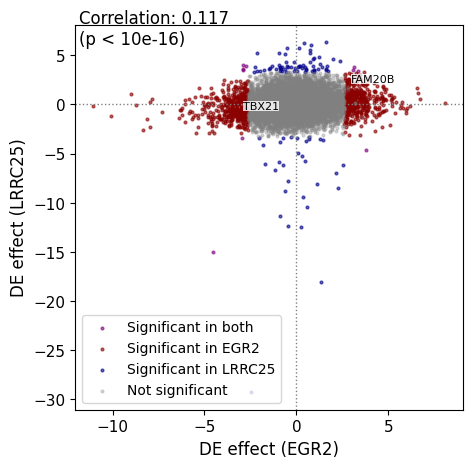

In [98]:
fig, ax = plt.subplots(figsize=(5, 5))
pl = plot_effect_comparison(
    adata_de, 
    {'target_contrast_gene_name':['EGR2', 'LRRC25'], 'stat':['zscore'], 'culture_condition':['Stim8hr']},
    annotate_significant=True, n_top_genes=5, plot_correlation=True, 
    annotate_genes = ['TBX21', 'FAM20B'],
    ax=ax
    )
ax.set_title('')

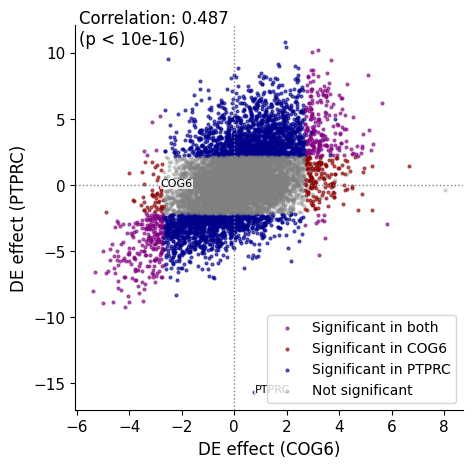

In [92]:
fig, ax = plt.subplots(figsize=(5, 5))
pl = plot_effect_comparison(
    adata_de, 
    {'target_contrast_gene_name':['COG6', 'PTPRC'], 'stat':['zscore'], 'culture_condition':['Stim48hr']},
    annotate_significant=True, n_top_genes=5, plot_correlation=True, 
    annotate_genes = ['COG6', 'PTPRC'],
    ax=ax
    )
ax.set_title('')
sns.despine()
plt.savefig('./results/COG6_scatter_example.pdf')
plt.savefig('./results/COG6_scatter_example.png')

In [91]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats[de_stats['target_name'] == 'IMMP1L']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
5663,ENSG00000148950,IMMP1L,Rest,458.0,152,225,377,-7.138805,True,12.811071,True,>10 DE genes,on-target KD
9062,ENSG00000148950,IMMP1L,Stim48hr,430.0,11,16,27,-7.756213,True,18.405776,True,>10 DE genes,on-target KD
20163,ENSG00000148950,IMMP1L,Stim8hr,487.0,42,46,88,-8.734796,True,16.222329,True,>10 DE genes,on-target KD


In [281]:
### Cluster 66

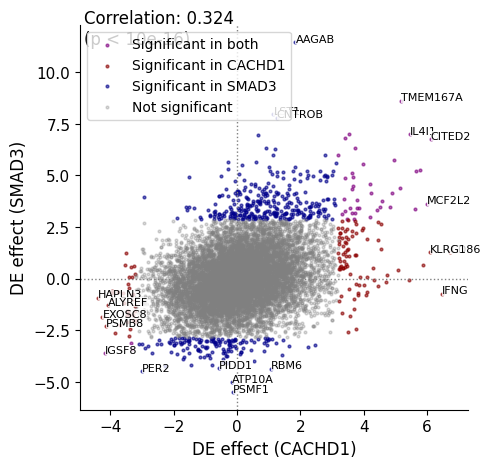

In [196]:
fig, ax = plt.subplots(figsize=(5, 5))
pl = plot_effect_comparison(
    adata_de, 
    {'target_contrast_gene_name':['SMAD3', 'CACHD1'], 'stat':['zscore'], 'culture_condition':['Stim8hr']},
    annotate_significant=True, n_top_genes=5, plot_correlation=True, 
    # annotate_genes = top_down_gs[0:10] + top_up_gs[0:10],
    ax=ax
    )
ax.set_title('')
sns.despine()
plt.savefig('./results/CACHD1_scatter_example.pdf')
plt.savefig('./results/CACHD1_scatter_example.png')

In [290]:
df = get_DE_results_long(adata_de, targets=['CACHD1'])

In [285]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats[de_stats['target_name'] == 'CACHD1']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
6314,ENSG00000158966,CACHD1,Rest,316.0,44,13,57,0.0,False,NaN,False,>10 DE genes,no on-target KD
19665,ENSG00000158966,CACHD1,Stim48hr,219.0,47,19,66,0.0,False,NaN,False,>10 DE genes,no on-target KD
23214,ENSG00000158966,CACHD1,Stim8hr,240.0,118,41,159,0.0,False,NaN,False,>10 DE genes,no on-target KD


## Cluster 76

In [49]:
cl_id = 76
cl_members = clustering_df[clustering_df['cluster'] == cl_id]['cluster_member'].iloc[0]
print(cl_members)
# Get results for disease-associated genes
res_df = get_DE_results_long(
    adata_de, 
    targets=cl_members
    )
res_df = res_df[res_df['culture_condition'] == 'Rest'].copy()

['PLAT', 'LCK', 'PTPRC', 'SKIV2L', 'TMX1', 'SLC3A2', 'UBE2E2', 'LRBA', 'CALCOCO2', 'FITM2', 'PGGT1B', 'MTA3', 'ITK', 'APPL2', 'GPRASP1', 'PLEK2', 'ARHGAP27', 'MBD5']


In [50]:
print_enrichment_summary(enrichment_df[(enrichment_df['disease'] == 'asthma') & (enrichment_df['cluster'] == cl_id)].iloc[0], clustering_df)


Cluster 76 - asthma
--------------------------------------------------
Significance: p < 0.05
Enrichment: 4/18 genes (22.2%)
Odds Ratio: 5.22
P-value: 1.33e-02

CORUM Complex: CD4 receptor complex
Reactome Pathway: REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES
KEGG Pathway: KEGG_PRIMARY_IMMUNODEFICIENCY

Disease-associated genes (4):
  PTPRC, UBE2E2, ARHGAP27, ITK


In [51]:
clustering_df[clustering_df['cluster'] == cl_id].iloc[0]

cluster                                                                         76
intracluster_corr                                                         0.609284
related_cluster                                                              {158}
rest_count                                                                       0
stim8hr_count                                                                   18
stim48hr_count                                                                   0
signature_gene                                                                 NaN
cluster_member                   [PLAT, LCK, PTPRC, SKIV2L, TMX1, SLC3A2, UBE2E...
manual_annotation                         T-cell signaling, related to cluster 158
complex_corum                                                 CD4 receptor complex
overlap_genes_corum                                               ['PTPRC', 'LCK']
overlap_fraction_corum                                                    0.111111
raw_

In [52]:
enrichment_df[(enrichment_df['disease'] == 'asthma') & (enrichment_df['cluster'] == cl_id)].sort_values('p_value')

,disease,cluster,cluster_size,disease_gene_count,disease_genes,odds_ratio,odds_ratio_ci_lower,odds_ratio_ci_upper,p_value,enrichment_fold,p_adj_fdr,cluster_annotation
439,asthma,76,18,4,"['PTPRC', 'UBE2E2', 'ARHGAP27', 'ITK']",5.215873,1.682724,16.167433,0.013335,4.13948,0.353378,"T-cell signaling, related to cluster 158"


In [53]:
res_df['signif_up'] = np.where(res_df['significant'] & (res_df['zscore'] > 0), res_df['zscore'], 0)
res_df['signif_down'] = np.where(res_df['significant'] & (res_df['zscore'] < 0), res_df['zscore'], 0)

top_up_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_up').mean(1).sort_values(ascending=False)[0:50].index.tolist()
top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').mean(1).sort_values(ascending=True)[0:50].index.tolist()
# [0:60].index.tolist()
# top_down_gs = res_df.pivot(index='gene', columns='target_contrast_gene_name', values='signif_down').sum(1).sort_values(ascending=False)[0:60].index.tolist()

print("Top upregulated genes:")
print(",\n".join([", ".join(top_up_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))
print("\nTop downregulated genes:") 
print(",\n".join([", ".join(top_down_gs[i:i+10]) for i in range(0, len(top_up_gs), 10)]))

Top upregulated genes:
CYFIP2, RHOB, KLF6, EZR, IGSF9B, RHOA, KRAS, TSC22D3, ADGRE5, MAP3K4,
FOSL2, YWHAH, JAK2, IFITM2, SMAGP, CCSER2, CLDND1, NEK7, PATJ, TRAK2,
TMEM71, STAT6, CPNE1, GBP5, NFKBIZ, PCGF5, STK38L, CHCHD7, MARCHF8, KLRG1,
EMP3, MAP4, IFNG, CA6, S100A11, IL7R, PCM1, GLIPR2, RYBP, SELPLG,
SREBF1, JAZF1, TRIM22, JUN, FLNB, ILK, S100A10, GFUS, HBEGF, FTL

Top downregulated genes:
PTPRC, LAT, TMX1, ZAP70, CALCOCO2, CD3G, LRBA, CD3D, APPL2, LCK,
MTA3, CD3E, ARHGAP27, SLC3A2, EBP, ACTG1, BIN2, CXCR6, ELL2, GNLY,
PLCB2, GLIPR1, ITK, CD247, CDC37, PLCG1, MYDGF, OXCT1, C12orf75, CHMP4A,
CNN2, SEPTIN6, GATAD2B, PHF23, JAML, MKNK2, IRAK4, RNASET2, CBX5, CKAP2L,
BIRC5, TCF3, HNRNPA2B1, DENND2D, YBX3, TPX2, PKM, CORO1A, FUT8, MELK


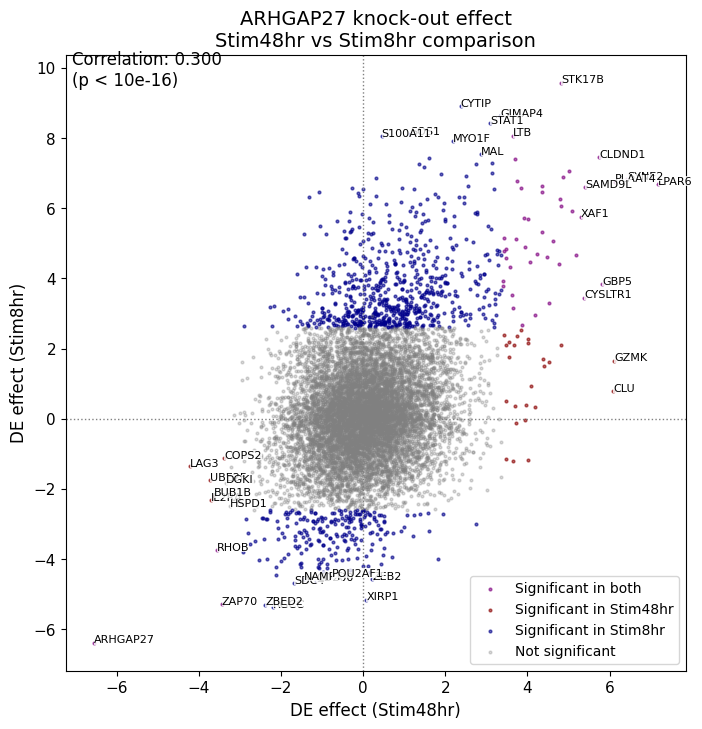

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
pl = plot_effect_comparison(
    adata_de, 
    {'target_contrast_gene_name':['ARHGAP27'], 'stat':['zscore'], 'culture_condition':['Stim8hr', "Stim48hr"]},
    annotate_significant=True, n_top_genes=10, plot_correlation=True,
    ax=ax
    );

In [55]:
de_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
de_stats[de_stats['target_name'] == 'ARHGAP27']

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
7267,ENSG00000159314,ARHGAP27,Stim48hr,201.0,68,8,76,-6.550189,True,29.924287,False,>10 DE genes,on-target KD
30197,ENSG00000159314,ARHGAP27,Stim8hr,234.0,709,225,934,-6.386096,True,23.812385,False,>10 DE genes,on-target KD
33364,ENSG00000159314,ARHGAP27,Rest,239.0,4,5,9,-8.555445,True,39.534745,False,2-10 DE genes,on-target KD


## Check genetic associations for follow-up hits in curation from Minikel et al. 

In [56]:
minikel_tab = pd.read_table('assoc.tsv.gz')

minikel_tab[
    (minikel_tab['gene'] == "ARHGAP27") & 
    (minikel_tab['original_trait'].str.contains('sthma', case=False))
].original_trait.unique()

array(['Asthma (childhood onset)', 'Age asthma diagnosed',
       'Allergic disease (asthma, hay fever or eczema)'], dtype=object)

In [57]:
minikel_tab[
    (minikel_tab['gene'] == "COG6") & 
    (minikel_tab['original_trait'].str.contains('sthma', case=False))
].original_trait.unique()

array(['Asthma (adult onset)', 'Asthma'], dtype=object)